<a href="https://colab.research.google.com/github/motho17/U-SAM-hybrid-model/blob/main/sam_only_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ssh-keygen -t rsa -b 4096

Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): 
Created directory '/root/.ssh'.
Enter passphrase (empty for no passphrase): 
Enter same passphrase again: 
Your identification has been saved in /root/.ssh/id_rsa
Your public key has been saved in /root/.ssh/id_rsa.pub
The key fingerprint is:
SHA256:jWhESGHhKcOKyPLMFJe3R6DOV/LfdSZAuX07y4xsccg root@2a166af1a761
The key's randomart image is:
+---[RSA 4096]----+
|   .=+o     ..   |
| . o.= .   ..    |
|  = * + o   .o   |
|+. B o B o  ... .|
|=.. o = S . . +.+|
|.=   o . . . E B |
|  +       . o * o|
|             + + |
|            .    |
+----[SHA256]-----+


In [6]:
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts


# github.com:22 SSH-2.0-babeld-d815c248


In [7]:
!cat /root/.ssh/id_rsa.pub

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQCnPk3FesXOa0GDAQLF4FvyDnl8kIatT2uuidoIFxdb0x1UWu6v8IFQ1W+xtH01kcT0oqGjT8u2Jt4JkjuKSNHiDWIG8KTutHJ82l+w/GZITyQV2nw8CDy15n7W9uf8EUKPBqH0hcKn+MjzlDmBAOL/4HzGblExptwEHNa5dciVC0ejyRR46u9AQwFDJsu3V6s/Qng7iusswPjwBccJnc3a5nGbXZdsl6vZI0faezBEyUIYLOPXp68V2AOowl1B8zbNDJJc1MdnoCyzOa/fVFt7RIfxp4JDxMem1N+k1VYgb+FeD8SPafVYXLyfWygg+yojxqbsLCGILqvNwLtB1u1DTOw+TFDUIHe+KZb5kiKTYTkUDcLNZGQqU5gd5gmgRdeTyB6LGfCol0NJOuombUEBRPq9fEnkQRZFHkGcg+Ar4xEc+n1pkbsTbAL2FBMkddu8ko1Vtoh9R/uQgI+BOZd1qmGGY7Er2HEav03A+rtC5X/LT8oKJSW9LhJJaFW4xSS3KPME85yuSuvKlXvkyseqg9NdwFKG0YYu+ID0FSNMgGo0GhhGCGH5FQ4q3jqD8TC6G9guNko3TSzaCUn8ccS2drzfL/GYolY4BiUA6dbqmw0jabyML+KB9Ua1jPoKxI87MHd1sCM3kRTBwBcePV0mGRHd8Bql7JYpZSgNbtQxfQ== root@2a166af1a761


In [8]:
!ssh -T git@github.com
!git config --global user.email "joycegitau17@gmail.com"
!git config --global user.name "motho17"
!git clone git@github.com:motho17/U-SAM-hybrid-model.git

Hi motho17/U-SAM-hybrid-model! You've successfully authenticated, but GitHub does not provide shell access.
Cloning into 'U-SAM-hybrid-model'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 71 (delta 15), reused 65 (delta 14), pack-reused 0
Receiving objects: 100% (71/71), 49.19 KiB | 223.00 KiB/s, done.
Resolving deltas: 100% (15/15), done.


In [9]:
!cd U-SAM-hybrid-model

In [2]:
!pip install torchio
!pip install torchsummary
using_colab = True
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    # !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.8/172.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 35.7 MB/s eta 0:00:00
PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True


In [3]:
import sys
import importlib

sys.path.append('/content/drive/MyDrive')
# usam = importlib.import_module('U-SAM-hybrid-model')
from sam.segment_anything import sam_model_registry,SamAutomaticMaskGenerator, SamPredictor
from sam.segment_anything.utils.transforms import ResizeLongestSide

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import glob
import os
import cv2
import nibabel as nib
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms as pth_transforms
from PIL import Image
import random
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import MinMaxScaler #scale values
import time
import torchio as tio
import torch.nn as nn
import tempfile
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2
import sklearn
from sklearn.model_selection import StratifiedKFold
from skimage.util import montage

In [ ]:
# !unzip '/content/drive/MyDrive/BraTs (1).zip' -d '/content/BraTs2020'

In [5]:
!unzip '/content/drive/MyDrive/BraTs2.zip' -d '/content/BraTs2020'

Streaming output truncated to the last 5000 lines.
  inflating: /content/BraTs2020/content/BraTs2/3830/t2.jpg  
  inflating: /content/BraTs2020/content/BraTs2/3830/seg.jpg  
   creating: /content/BraTs2020/content/BraTs2/4529/
  inflating: /content/BraTs2020/content/BraTs2/4529/t1ce.jpg  
  inflating: /content/BraTs2020/content/BraTs2/4529/flair.jpg  
  inflating: /content/BraTs2020/content/BraTs2/4529/t1.jpg  
  inflating: /content/BraTs2020/content/BraTs2/4529/t2.jpg  
  inflating: /content/BraTs2020/content/BraTs2/4529/seg.jpg  
   creating: /content/BraTs2020/content/BraTs2/20978/
  inflating: /content/BraTs2020/content/BraTs2/20978/t1ce.jpg  
  inflating: /content/BraTs2020/content/BraTs2/20978/flair.jpg  
  inflating: /content/BraTs2020/content/BraTs2/20978/t1.jpg  
  inflating: /content/BraTs2020/content/BraTs2/20978/t2.jpg  
  inflating: /content/BraTs2020/content/BraTs2/20978/seg.jpg  
   creating: /content/BraTs2020/content/BraTs2/27801/
  inflating: /content/BraTs2020/conten

In [4]:
from glob import glob
import os
imgs_dir='/content/BraTs2020/content/BraTs2'
all_dirs = glob (f'{imgs_dir}/*')
all_dirs = all_dirs
len (all_dirs)

35380

In [4]:
from glob import glob
import os
imgs_dir='/content/BraTs2020/content/BraTs2'
all_dirs = glob (f'{imgs_dir}/*')
all_dirs = all_dirs[0:1000]
# print(len(all_dirs))
all_dirs.sort()
# a = glob('/Users/jojo/Downloads/content/BraTs')
# print(a[0:10])

#split the data into training and validation data
def shuffle_split (all_dirs, val_pct = 0.19,train_pct = 0.8, seed = 99):
    """ shuffling dataset with random state and split to train and valid """
    n_train = int (len (all_dirs) * train_pct)
    n_val = int (len (all_dirs) * val_pct)+n_train

    np.random.seed (seed)
    idx = np.random.permutation (len (all_dirs))
    all_dirs = np.array (all_dirs) [idx]
#     return all_dirs [n_val:], all_dirs [:n_val]

# train_dirs, valid_dirs = shuffle_split (all_dirs, seed = 1)
# print(len(valid_dirs)), print(len(train_dirs))

    return all_dirs [:n_train], all_dirs [n_train:n_val],all_dirs [n_val:]

train_dirs, valid_dirs,test_dirs = shuffle_split (all_dirs, seed = 1)
print(len(train_dirs))
print(len(valid_dirs))
print(len(test_dirs))

800
190
10


In [6]:
from glob import glob
import os
imgs_dir='/content/BraTs2020/content/BraTs2'
all_dirs = glob (f'{imgs_dir}/*')
all_dirs = all_dirs
# print(len(all_dirs))
all_dirs.sort()
def shuffle_split (all_dirs, val_pct = 0.15, seed = 99):
    """ shuffling dataset with random state and split to train and valid """
    n_val = int (len (all_dirs) * val_pct)
    np.random.seed (seed)
    idx = np.random.permutation (len (all_dirs))
    all_dirs = np.array (all_dirs) [idx]

    return all_dirs [n_val:], all_dirs [:n_val]

train_dirs, valid_dirs = shuffle_split (all_dirs, seed = 1)
print(len(valid_dirs)), print(len(train_dirs))

5307
30073


(None, None)

In [7]:
class BratsDataset (Dataset):
  def __init__ (self, img_dirs, modality_types, transform = None):
      self.img_dirs = img_dirs
      self.transform = transform

  def __len__ (self):
      return len (self.img_dirs)

  def __getitem__ (self, index):
      imgs_path = self.img_dirs [index]
      image = self.concat_imgs (imgs_path)
      mask = np.array (Image.open (f'{imgs_path}/seg.jpg'))
      mask = (mask / 255 * 4).round ()
      mask = self.preprocess_mask_labels(mask)

      image = image.transpose(2, 1, 0)  # (B, H, W, C) to (B, C, H, W)
      mask = mask.transpose(2, 1, 0)  # (C, H, W) to (B, C, H, W)
      # print(image.shape)
      # print(mask.shape)


      if self.transform is not None:
          augmented = self.transform(image = image, mask = mask)
          image = augmented ['image']
          mask = augmented ['mask']
      image = image.permute(0,1,2)  # (B, H, W, C) to (B, C, H, W)
      mask = mask.permute(2, 0, 1)  # (C, H, W) to (B, C, H, W)
      # print(image.shape)
      # print(mask.shape)
      bboxes = self.get_bounding_box(mask)


      # return image.astype(float), mask.astype(float),bboxes
      # return image.float(), mask.float(),bboxes
      # return image.astype(np.float), mask.astype(np.float),bboxes
      return image,mask,bboxes


  def concat_imgs (self, path: str):
      types = []
      for modality_type in modality_types:
          img = np.array (Image.open (f'{path}/{modality_type}.jpg'))
          img = self.normalize(img)
          types.append (img)
#         cat_img = np.concatenate (types, axis = -1)

      return np.array(types)
  def get_bounding_box(self, mask):
    ground_truth_map = mask[0]# Extract the first channel of the mask

    # Find the indices of non-zero elements in the ground truth map
    y_indices, x_indices = np.where(ground_truth_map > 0)

    # Calculate the minimum and maximum values for x and y coordinates
    try:
      x_min = np.min(x_indices)
      y_min = np.min(y_indices)
      x_max = np.max(x_indices)
      y_max = np.max(y_indices)

    except ValueError:
      x_min = 0
      y_min = 0
      x_max = 0
      y_max = 0
    bboxes = np.array([x_min, y_min, x_max, y_max])

    return bboxes

  def preprocess_mask_labels(self, mask: np.ndarray):
      mask_WT = np.zeros(mask.shape)
      mask_WT[mask == 2] = 1

      mask_TC = np.zeros(mask.shape)
      mask_TC[mask == 1] = 1

      mask_ET = np.zeros(mask.shape)
      mask_ET[mask == 3] = 1

      mask_BG = np.zeros(mask.shape)
      mask_BG[mask == 0] = 1

      mask = np.stack([mask_WT, mask_TC, mask_ET])#, mask_BG
      # mask = np.moveaxis(mask, (0, 1, 2), (0, 2, 1))
      return mask

  def normalize(self, data: np.ndarray):
      data_min = np.min(data)
      if np.max(data) == 0:
          return data
      if (np.max(data) - data_min) == 0:
          return data / data_min

      return (data - data_min) / (np.max(data) - data_min)


modality_types = ['flair', 't1', 't1ce']#,'t2'

trn_tfms = A.Compose([
    A.Resize(height=256, width=256),
    A.HorizontalFlip (p = 0.5),
    ToTensorV2(),
])

val_tfms = A.Compose([
    A.Resize(height=256, width=256),
    ToTensorV2(),
])


In [16]:
! nvidia-smi

Sat Aug 12 01:51:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    48W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
# seed = 1234
# num_classes = 3
# def worker_init_fn(worker_id):
#         random.seed(seed + worker_id)




train_ds = BratsDataset(train_dirs, modality_types,transform = trn_tfms)
train_dl = DataLoader(train_ds, batch_size = 10, shuffle = False, num_workers = 2)

valid_ds = BratsDataset(valid_dirs, modality_types,transform = val_tfms)
valid_dl = DataLoader(valid_ds, batch_size = 1, shuffle = False, num_workers = 2)


# test_ds = BratsDataset(test_dirs, modality_types,transform = val_tfms)
# test_dl = DataLoader(test_ds, batch_size = 1, shuffle = False, num_workers = 2, pin_memory = True)

In [ ]:
print(len(valid_ds))

9645


In [ ]:
for images,masks,bboxes in valid_dl:
  print
  #  print(f"{images.shape=}, {masks.shape=},{bboxes.shape=}")
  #  val, counts = np.unique(masks, return_counts=True)
  #  if(1 - (counts[0]/counts.sum())) > 0.01:
  #   print('yes')
  #  else:
  #   print('no')

  #  print(bboxes)
  #  break

In [ ]:
for step, (images, masks, bboxes) in enumerate(tqdm(valid_dl)):
  # print(bboxes)
  if step == 1:
    print('yes')
    global image_temp
    image_temp = None
    val, counts = np.unique(masks, return_counts=True)
    print(1 - (counts[0]/counts.sum()))
    if(1 - (counts[0]/counts.sum())) > 0.01:
      print(str(step)+'step')
      image_temp = images
      #images = images
      plt.imshow(images.squeeze(0).permute(1,2,0).cpu().numpy())






  0%|          | 1/9645 [00:05<14:10:04,  5.29s/it]

0.00022379557291662966
0.0
0.02305094401041663
...............
2
torch.Size([3, 256, 256])
tensor([ 91, 121, 189, 196])


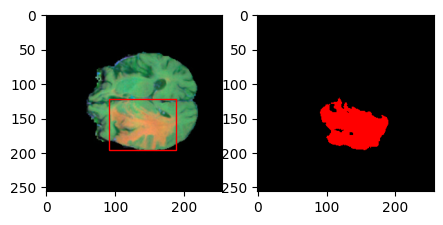

  0%|          | 3/9645 [00:05<4:14:46,  1.59s/it] 

0.0
0.00751241048177087
0.0005645751953125
0.01111857096354163
...............
6
torch.Size([3, 256, 256])
tensor([105,  66, 171, 123])


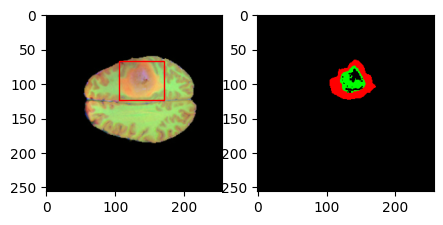

  0%|          | 7/9645 [00:06<1:29:53,  1.79it/s]

0.0
0.0
0.0
0.01217142740885413
...............
10
torch.Size([3, 256, 256])
tensor([ 73, 124, 151, 166])


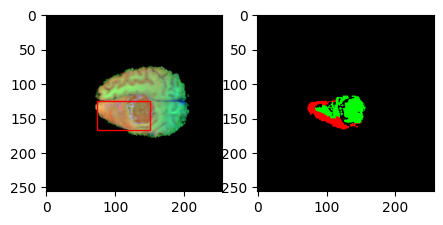

  0%|          | 11/9645 [00:06<51:21,  3.13it/s] 

0.001708984375
0.0
0.00409444173177087
0.0
0.03481038411458337
...............
15
torch.Size([3, 256, 256])
tensor([ 61,  64, 156, 166])


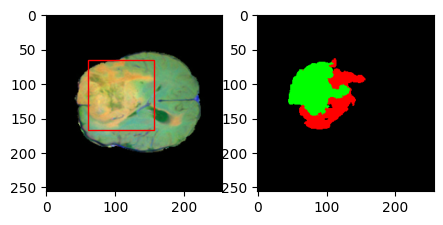

  0%|          | 16/9645 [00:06<31:48,  5.05it/s]

0.0
0.00506083170572913
0.0
0.0
0.0
0.0
0.0207366943359375
...............
22
torch.Size([3, 256, 256])
tensor([ 94, 125, 193, 194])


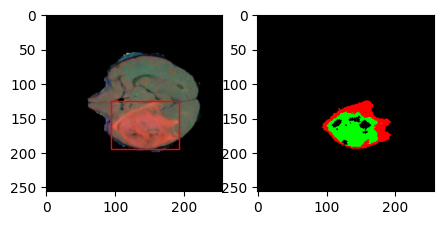

  0%|          | 23/9645 [00:07<19:58,  8.03it/s]

0.0029500325520833703
0.0
0.0
0.00726826985677087
0.0144500732421875
...............
27
torch.Size([3, 256, 256])
tensor([108,  62, 213, 133])


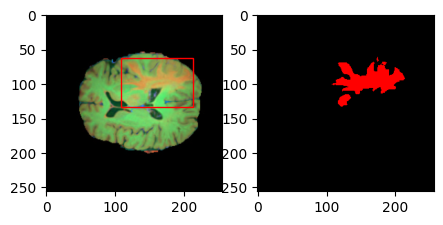

  0%|          | 28/9645 [00:07<16:36,  9.65it/s]

0.01500956217447913
...............
28
torch.Size([3, 256, 256])
tensor([ 47, 118, 148, 187])


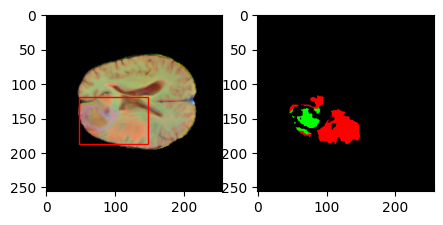

  0%|          | 45/9645 [00:07<07:07, 22.48it/s]

0.0
0.0
0.00043233235677087034
0.00615437825520837
0.00594584147135413
0.0019022623697916297
0.0
0.0
0.0
0.0008799235026041297
0.005859375
0.008087158203125
0.00900777180989587
0.0
1.017252604162966e-05
0.0030873616536458703
0.0041351318359375
0.0
0.0
0.00628662109375
0.00652567545572913
0.00428263346354163
0.0
0.006103515625
0.0038503011067708703
0.0
0.0
0.0
0.0
0.0


  1%|          | 60/9645 [00:07<04:15, 37.52it/s]

0.0006103515625
0.0
0.0
0.0
0.00014241536458337034
0.0
0.01228841145833337
...............
65
torch.Size([3, 256, 256])
tensor([ 98,  61, 167, 102])


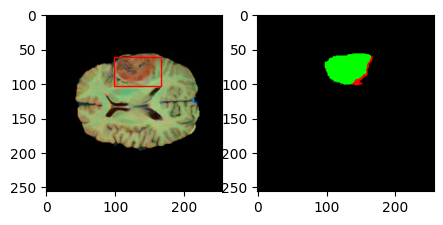

  1%|          | 69/9645 [00:08<04:39, 34.22it/s]

0.0027872721354166297
0.00038655598958337034
0.0
0.0034535725911458703
0.0
0.0022532145182291297
0.0
0.0121307373046875
...............
73
torch.Size([3, 256, 256])
tensor([104,  64, 197, 105])


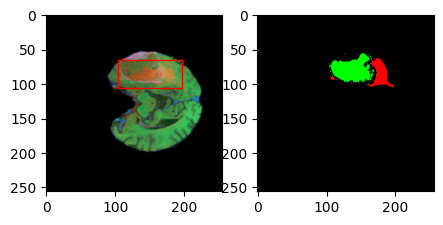

  1%|          | 76/9645 [00:08<05:15, 30.31it/s]

0.0
0.0
0.01442972819010413
...............
76
torch.Size([3, 256, 256])
tensor([ 87, 132, 155, 195])


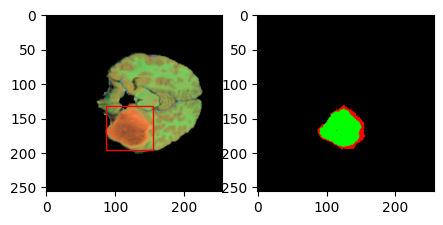

  1%|          | 82/9645 [00:08<05:49, 27.33it/s]

0.0
0.0
0.0
0.0006357828776041297
0.0
0.00831095377604163
0.0
0.0
0.008331298828125
0.0
0.0
0.0
0.0037434895833333703
0.0
0.01290384928385413
...............
91
torch.Size([3, 256, 256])
tensor([ 91,  63, 165, 105])


  1%|          | 91/9645 [00:09<15:49, 10.07it/s]


KeyboardInterrupt: ignored

In [ ]:
from segment_anything.utils.transforms import ResizeLongestSide
import matplotlib.patches as patches


# for images,masks,bboxes in valid_dl:
for step, (images, masks, bboxes) in enumerate(tqdm(valid_dl)):
    # images = images.repeat(1, 3, 1, 1)
    # img_embed: (B, 256, 64, 64), gt2D: (B, 1, 256, 256), bboxes: (B, 4)
    val, counts = np.unique(masks, return_counts=True)
    print(1 - (counts[0]/counts.sum()))
    if(1 - (counts[0]/counts.sum())) > 0.01:
      for i in range(images.shape[0]):
        print('...............')
        print(step)
        image = images[i]
        # image = torch.squeeze(image, dim=1)
        # print(image.shape)
        # image = np.uint8(image.permute(1,2,0).numpy())
        print(image.shape)
        mask = masks[i]
        bbox = bboxes[i]
        print(bbox)

        plt.figure(figsize=(5,5))
        plt.subplot(1,2,1)
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0],bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none')
        plt.imshow((image.permute(1,2,0).numpy()),cmap="bone")
        plt.gca().add_patch(rect)

        plt.subplot(1,2,2)
        plt.imshow(mask.permute(1,2,0),cmap="gray"
)
        plt.show()

        # print(f"{images.shape=}, {masks.shape=},{bboxes.shape=}")
        # print(bboxes)
        # # print(masks)
        break

In [9]:
# from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/content/drive/MyDrive/SAM/sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda"

sam_model = sam_model_registry[model_type](checkpoint=sam_checkpoint,num_classes = 3)
sam_model.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam_model)

In [10]:
sam_model.to(device=device)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [11]:
!pip install monai
!pip install tensorboardX


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 2.2 MB/s eta 0:00:00


In [12]:
from torch.autograd import Function
class DiceCoeff(Function):
    """Dice coeff for individual examples"""

    def forward(self, input, target):
        self.save_for_backward(input, target)
        eps = 0.0001
        self.inter = torch.dot(input.view(-1), target.view(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target


def dice_coeff(input, target):
    """Dice coeff for batches"""
    if input.is_cuda:
        s = torch.FloatTensor(1).to(device = input.device).zero_()
    else:
        s = torch.FloatTensor(1).zero_()

    for i, c in enumerate(zip(input, target)):
        s = s + DiceCoeff().forward(c[0], c[1])

    return s / (i + 1)

def iou(outputs: np.array, labels: np.array):

    SMOOTH = 1e-6
    intersection = (outputs & labels).sum((1, 2))
    union = (outputs | labels).sum((1, 2))

    iou = (intersection + SMOOTH) / (union + SMOOTH)


    return iou.mean()

def eval_seg(pred,true_mask_p,threshold):
    '''
    threshold: a int or a tuple of int
    masks: [b,2,h,w]
    pred: [b,2,h,w]
    '''
    b, c, h, w = pred.size()
    if c == 2:
        iou_d, iou_c, disc_dice, cup_dice = 0,0,0,0
        for th in threshold:

            gt_vmask_p = (true_mask_p > th).float()
            vpred = (pred > th).float()
            vpred_cpu = vpred.cpu()
            disc_pred = vpred_cpu[:,0,:,:].numpy().astype('int32')
            cup_pred = vpred_cpu[:,1,:,:].numpy().astype('int32')

            disc_mask = gt_vmask_p [:,0,:,:].squeeze(1).cpu().numpy().astype('int32')
            cup_mask = gt_vmask_p [:, 1, :, :].squeeze(1).cpu().numpy().astype('int32')

            '''iou for numpy'''
            iou_d += iou(disc_pred,disc_mask)
            iou_c += iou(cup_pred,cup_mask)

            '''dice for torch'''
            disc_dice += dice_coeff(vpred[:,0,:,:], gt_vmask_p[:,0,:,:]).item()
            cup_dice += dice_coeff(vpred[:,1,:,:], gt_vmask_p[:,1,:,:]).item()

        return iou_d / len(threshold), iou_c / len(threshold), disc_dice / len(threshold), cup_dice / len(threshold)
    else:
        eiou, edice = 0,0
        for th in threshold:

            gt_vmask_p = (true_mask_p > th).float()
            vpred = (pred > th).float()
            vpred_cpu = vpred.cpu()
            disc_pred = vpred_cpu[:,0,:,:].numpy().astype('int32')

            disc_mask = gt_vmask_p [:,0,:,:].squeeze(1).cpu().numpy().astype('int32')

            '''iou for numpy'''
            eiou += iou(disc_pred,disc_mask)

            '''dice for torch'''
            edice += dice_coeff(vpred[:,0,:,:], gt_vmask_p[:,0,:,:]).item()

        return eiou / len(threshold), edice / len(threshold)


In [13]:

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
)
from monai.metrics import DiceMetric
# from segment_anything import sam_model_registry
# from segment_anything.utils.transforms import ResizeLongestSide


GPUdevice = "cuda"
pos_weight = torch.ones([1]).cuda(device=GPUdevice)*2
criterion_G = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
seed = torch.randint(1,11,(1,7))

torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
scaler = torch.cuda.amp.GradScaler()
max_iterations = 100#number of iterations
post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot= 3)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
train_logs = []


def train_sam(model, optimizer, train_loader,
          epoch, schedulers=None):
    hard = 0
    epoch_loss = 0
    ind = 0
    # train mode
    sam_model.train()
    optimizer.zero_grad()
    threshold = (0.1, 0.3, 0.5, 0.7, 0.9)

    epoch_loss = 0
    GPUdevice = "cuda"
    use_amp = False

    device = GPUdevice
    # lossfunc = DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
    scaler = torch.cuda.amp.GradScaler()

    lossfunc = DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

    if use_amp:
      scaler = torch.cuda.amp.GradScaler()

    accumulation_steps = 4

    for param in sam_model.prompt_encoder.parameters():
            param.requires_grad = False

    for param in sam_model.image_encoder.parameters():
            param.requires_grad = False


    with tqdm(total=len(train_loader), desc=f'Epoch {epoch}', unit='img') as pbar:
        for ind,(image_embedding, gt2D, boxes) in enumerate(train_loader):
            # val, counts = np.unique(gt2D, return_counts=True)
            # if(1 - (counts[0]/counts.sum())) > 0.01:
              sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
              trans_image = sam_trans.apply_image_torch(image_embedding)
              trans_image = trans_image.float()
              trans_image = trans_image.to(device)

              image_embedding = sam_model.image_encoder(trans_image)
              # convert box to 1024x1024 grid
              box_np = boxes.numpy()
              sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
              box = sam_trans.apply_boxes(box_np, (gt2D.shape[-2], gt2D.shape[-1]))
              box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
              if len(box_torch.shape) == 2:
                  box_torch = box_torch[:, None, :] # (B, 1, 4)
              # #     print(k)

              with torch.no_grad():

                  sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                  points=None,
                  boxes=box_torch,
                  masks=None,
              )
              batch_size = image_embedding.size(0)
              # dense_prompt_embeddings = dense_embeddings.repeat(batch_size, 1, 1, 1)

              with torch.autocast(device_type="cuda", dtype=torch.float16):
                  pred, _ = sam_model.mask_decoder(
                  image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
                  image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
                  sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
                  dense_prompt_embeddings=dense_embeddings, #dense_embeddings.repeat(image_embedding.size(0), 1, 1, 1), # (B, 256, 64, 64)
                  multimask_output=True,
                )
                  loss = lossfunc(pred,gt2D.to(device))

              scaler.scale(loss).backward()
              if (ind + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()


              # else:
              # pred, _ = sam_model.mask_decoder(
              #     image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
              #     image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
              #     sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
              #     dense_prompt_embeddings=dense_embeddings, #dense_embeddings.repeat(image_embedding.size(0), 1, 1, 1), # (B, 256, 64, 64)
              #     multimask_output=True,
              #   )

              # loss = lossfunc(pred,gt2D.to(device))


              pbar.set_postfix(**{'loss (batch)': loss.item()})
              epoch_loss += loss.item()
              # loss.backward()
              train_logs.append(epoch_loss)

              # nn.utils.clip_grad_value_(net.parameters(), 0.1)
              # optimizer.step()
              # optimizer.zero_grad()

              # '''vis images'''
              # if vis:
              #     if ind % vis == 0:
              #         namecat = 'Train'
              #         for na in name:
              #             namecat = namecat + na.split('/')[-1].split('.')[0] + '+'
              #         vis_image(imgs,pred,masks, os.path.join(args.path_helper['sample_path'], namecat+'epoch+' +str(epoch) + '.jpg'), reverse=False, points=showp)
              cleanup_interval = 4 # Adjust as needed
              if (ind + 1) % cleanup_interval == 0:
                  torch.cuda.empty_cache()
              pbar.update()

    return loss


In [14]:

# parser.add_argument('-evl_chunk', type=int, default=None , help='evaluation chunk')
def validation_sam(val_loader, epoch, model, clean_dir=True):
     # eval mode
    sam_model.eval()

    mask_type = torch.float32
    n_val = len(val_loader)  # the number of batch
    ave_res, mix_res = (0,0,0,0), (0,0,0,0)
    rater_res = [(0,0,0,0) for _ in range(6)]
    tot = 0
    hard = 0
    threshold = (0.1, 0.3, 0.5, 0.7, 0.9)
    GPUdevice = "cuda"
    device = GPUdevice
    evl_chunk = None
    n_val = len(val_loader)

    lossfunc = DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')


    with tqdm(total=n_val, desc='Validation round', unit='batch', leave=False) as pbar:
        for image_embedding, gt2D, boxes in (val_loader):
          # val, counts = np.unique(gt2D, return_counts=True)
          # if(1 - (counts[0]/counts.sum())) > 0.01:
            sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
            trans_image = sam_trans.apply_image_torch(image_embedding)
            trans_image = trans_image.float()
            trans_image = trans_image.to(device)
            if evl_chunk:
                evl_ch = int(evl_chunk)
            else:
                evl_ch = int(trans_image.size(-1))


            # image_embedding = sam_model.image_encoder(trans_image)
            # convert box to 1024x1024 grid
            box_np = boxes.numpy()
            sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
            box = sam_trans.apply_boxes(box_np, (gt2D.shape[-2], gt2D.shape[-1]))
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :] # (B, 1, 4)
            #     print(k)

            with torch.no_grad():
                # imge= net.image_encoder(imgs)
                image_embedding = sam_model.image_encoder(trans_image)
                sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )

                batch_size = image_embedding.size(0)
                dense_prompt_embeddings = dense_embeddings.repeat(batch_size, 1, 1, 1)

                pred, _ = sam_model.mask_decoder(
                    image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
                    image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
                    sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
                    dense_prompt_embeddings=dense_prompt_embeddings, #dense_embeddings.repeat(image_embedding.size(0), 1, 1, 1), # (B, 256, 64, 64)
                    multimask_output=True,
                  )


                tot += lossfunc(pred, gt2D.to(device))


                # '''vis images'''
                # if ind % args.vis == 0:
                #     namecat = 'Test'
                #     for na in name:
                #         img_name = na.split('/')[-1].split('.')[0]
                #         namecat = namecat + img_name + '+'
                #     vis_image(imgs,pred, masks, os.path.join(args.path_helper['sample_path'], namecat+'epoch+' +str(epoch) + '.jpg'), reverse=False, points=showp)


                temp = eval_seg(pred, gt2D.to(device), threshold)
                mix_res = tuple([sum(a) for a in zip(mix_res, temp)])


            pbar.update()

        if evl_chunk:
          n_val = n_val * (trans_image.size(-1) // evl_ch)

        return tot/ n_val , tuple([a/n_val for a in mix_res])



In [32]:
import torch
torch.cuda.empty_cache()

In [15]:
import os
join = os.path.join
work_dir = '/content/drive/MyDrive/SAM/'
task_name = 'sam_only3'
model_save_path = join(work_dir, task_name)
os.makedirs(model_save_path, exist_ok=True)

In [16]:
checkpoint_path = "/content/drive/MyDrive/SAM/sam_only2/sam_model_best.pth"
sam_model.load_state_dict(torch.load(checkpoint_path))
sam_model.train()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [17]:
from torch.optim import Adam
best_acc = 0.0
best_tol = 1e4
EPOCH = 10
val_freq = 100


optimizer = Adam(sam_model.mask_decoder.parameters(), lr=1e-5*0.01, weight_decay=0)
# optimizer = torch.optim.Adam([
#     dict(params=sam_model.parameters(), lr=1e-5, weight_decay=0),
# ])

for epoch in range(EPOCH):
    # if args.mod == 'sam_adpt':
      sam_model.train()
      time_start = time.time()
      loss = train_sam(model=sam_model, optimizer = optimizer, train_loader = train_dl, epoch= epoch)
      # logger.info(f'Train loss: {loss}|| @ epoch {epoch}.')

      print(f'Train loss: {loss}|| @ epoch {epoch}.')

      time_end = time.time()
      print('time_for_training ', time_end - time_start)
      # sam_model.eval()
      # val_loss = valid_sam(sam_model, optimizer, valid_dl, epoch)


      sam_model.eval()
      if epoch and epoch % val_freq == 0 or epoch == EPOCH-1:
          tol, (eiou, edice) = validation_sam(valid_dl, epoch, model= sam_model)
          # tol, (eiou, edice) = function.validation_sam(args, nice_test_loader, epoch, net, writer)
          print(f'Total score: {tol}, IOU: {eiou}, DICE: {edice} || @ epoch {epoch}.')



          sd = sam_model.state_dict()
          torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_latest.pth'))
          if tol < best_tol:
              best_tol = tol
              is_best = True
              torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_best.pth'))
          else:
            is_best = False
#3129.713501930237
#3191

Epoch 0: 100%|██████████| 3008/3008 [57:13<00:00,  1.14s/img, loss (batch)=0.131]


Train loss: 0.1310452854333754|| @ epoch 0.
time_for_training  3433.6699182987213


Epoch 1: 100%|██████████| 3008/3008 [57:04<00:00,  1.14s/img, loss (batch)=0.142]


Train loss: 0.14243050854482978|| @ epoch 1.
time_for_training  3424.45653796196


Epoch 2: 100%|██████████| 3008/3008 [57:03<00:00,  1.14s/img, loss (batch)=0.146]


Train loss: 0.14550360691700115|| @ epoch 2.
time_for_training  3423.2742438316345


Epoch 3: 100%|██████████| 3008/3008 [57:02<00:00,  1.14s/img, loss (batch)=0.133]


Train loss: 0.13274464230981403|| @ epoch 3.
time_for_training  3422.6210985183716


Epoch 4: 100%|██████████| 3008/3008 [57:12<00:00,  1.14s/img, loss (batch)=0.141]


Train loss: 0.1406851595714769|| @ epoch 4.
time_for_training  3432.616464614868


Epoch 5: 100%|██████████| 3008/3008 [57:11<00:00,  1.14s/img, loss (batch)=0.143]


Train loss: 0.14335028079967338|| @ epoch 5.
time_for_training  3431.5658526420593


Epoch 6: 100%|██████████| 3008/3008 [57:14<00:00,  1.14s/img, loss (batch)=0.141]


Train loss: 0.14137934270855607|| @ epoch 6.
time_for_training  3434.263943195343


Epoch 7: 100%|██████████| 3008/3008 [57:11<00:00,  1.14s/img, loss (batch)=0.131]


Train loss: 0.13050604097496282|| @ epoch 7.
time_for_training  3431.167948484421


Epoch 8: 100%|██████████| 3008/3008 [57:09<00:00,  1.14s/img, loss (batch)=0.133]


Train loss: 0.13314837565548263|| @ epoch 8.
time_for_training  3429.8600554466248


Epoch 9: 100%|██████████| 3008/3008 [57:11<00:00,  1.14s/img, loss (batch)=0.146]


Train loss: 0.14557265155951934|| @ epoch 9.
time_for_training  3431.4484581947327


Total score: 0.12900948645231552, IOU: 0.7338701021985088, DICE: 0.8152946809843824 || @ epoch 9.


In [18]:
train_logs_df = pd.DataFrame(train_logs)
from google.colab import files
train_logs_df.to_csv('train_logssam3_df.csv', encoding = 'utf-8-sig')
files.download('train_logssam3_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
checkpoint_path = "/content/drive/MyDrive/SAM/sam_only/sam_model_best.pth"
sam_model.load_state_dict(torch.load(checkpoint_path))
sam_model.train()

In [16]:
from torch.optim import Adam
best_acc = 0.0
best_tol = 1e4
EPOCH = 20
val_freq = 100


optimizer = Adam(sam_model.mask_decoder.parameters(), lr=1e-5*0.1, weight_decay=0)
# optimizer = torch.optim.Adam([
#     dict(params=sam_model.parameters(), lr=1e-5, weight_decay=0),
# ])

for epoch in range(EPOCH):
    # if args.mod == 'sam_adpt':
      sam_model.train()
      time_start = time.time()
      loss = train_sam(model=sam_model, optimizer = optimizer, train_loader = train_dl, epoch= epoch)
      # logger.info(f'Train loss: {loss}|| @ epoch {epoch}.')

      print(f'Train loss: {loss}|| @ epoch {epoch}.')

      time_end = time.time()
      print('time_for_training ', time_end - time_start)
      # sam_model.eval()
      # val_loss = valid_sam(sam_model, optimizer, valid_dl, epoch)


      sam_model.eval()
      if epoch and epoch % val_freq == 0 or epoch == EPOCH-1:
          tol, (eiou, edice) = validation_sam(valid_dl, epoch, model= sam_model)
          # tol, (eiou, edice) = function.validation_sam(args, nice_test_loader, epoch, net, writer)
          print(f'Total score: {tol}, IOU: {eiou}, DICE: {edice} || @ epoch {epoch}.')



          sd = sam_model.state_dict()
          torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_latest.pth'))
          if tol < best_tol:
              best_tol = tol
              is_best = True
              torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_best.pth'))
          else:
            is_best = False
#3129.713501930237
#3191

Epoch 0: 100%|██████████| 3008/3008 [57:13<00:00,  1.14s/img, loss (batch)=0.145]


Train loss: 0.14459222668050634|| @ epoch 0.
time_for_training  3433.6911902427673


Epoch 1: 100%|██████████| 3008/3008 [57:04<00:00,  1.14s/img, loss (batch)=0.138]


Train loss: 0.13752378549426172|| @ epoch 1.
time_for_training  3424.436138153076


Epoch 2: 100%|██████████| 3008/3008 [57:07<00:00,  1.14s/img, loss (batch)=0.136]


Train loss: 0.13621120736752532|| @ epoch 2.
time_for_training  3427.501702785492


Epoch 3: 100%|██████████| 3008/3008 [57:08<00:00,  1.14s/img, loss (batch)=0.144]


Train loss: 0.1440812510300862|| @ epoch 3.
time_for_training  3428.2081592082977


Epoch 4: 100%|██████████| 3008/3008 [57:15<00:00,  1.14s/img, loss (batch)=0.15]


Train loss: 0.15024753293029666|| @ epoch 4.
time_for_training  3435.8711462020874


Epoch 5: 100%|██████████| 3008/3008 [57:20<00:00,  1.14s/img, loss (batch)=0.145]


Train loss: 0.14496877473421574|| @ epoch 5.
time_for_training  3440.0171468257904


Epoch 6: 100%|██████████| 3008/3008 [57:18<00:00,  1.14s/img, loss (batch)=0.134]


Train loss: 0.13421990641596815|| @ epoch 6.
time_for_training  3438.187170267105


Epoch 7: 100%|██████████| 3008/3008 [57:19<00:00,  1.14s/img, loss (batch)=0.133]


Train loss: 0.13299208544622385|| @ epoch 7.
time_for_training  3439.4897418022156


Epoch 8: 100%|██████████| 3008/3008 [57:21<00:00,  1.14s/img, loss (batch)=0.141]


Train loss: 0.14050162310171793|| @ epoch 8.
time_for_training  3441.2612199783325


Epoch 9: 100%|██████████| 3008/3008 [57:21<00:00,  1.14s/img, loss (batch)=0.14]


Train loss: 0.14024688199291002|| @ epoch 9.
time_for_training  3441.6798412799835


Epoch 10: 100%|██████████| 3008/3008 [57:21<00:00,  1.14s/img, loss (batch)=0.142]


Train loss: 0.1424365941872244|| @ epoch 10.
time_for_training  3441.461135149002


Epoch 11: 100%|██████████| 3008/3008 [57:21<00:00,  1.14s/img, loss (batch)=0.139]


Train loss: 0.13918849504388373|| @ epoch 11.
time_for_training  3441.4839811325073


Epoch 12: 100%|██████████| 3008/3008 [57:20<00:00,  1.14s/img, loss (batch)=0.132]


Train loss: 0.132405268812872|| @ epoch 12.
time_for_training  3440.710631608963


Epoch 13: 100%|██████████| 3008/3008 [57:20<00:00,  1.14s/img, loss (batch)=0.141]


Train loss: 0.14121874864114245|| @ epoch 13.
time_for_training  3440.3883361816406


Epoch 14: 100%|██████████| 3008/3008 [57:21<00:00,  1.14s/img, loss (batch)=0.132]


Train loss: 0.13174438371716807|| @ epoch 14.
time_for_training  3441.569961309433


Epoch 15: 100%|██████████| 3008/3008 [57:21<00:00,  1.14s/img, loss (batch)=0.132]


Train loss: 0.1315069876740039|| @ epoch 15.
time_for_training  3441.6538820266724


Epoch 16: 100%|██████████| 3008/3008 [57:22<00:00,  1.14s/img, loss (batch)=0.14]


Train loss: 0.14033324547871692|| @ epoch 16.
time_for_training  3442.2395510673523


Epoch 17: 100%|██████████| 3008/3008 [57:20<00:00,  1.14s/img, loss (batch)=0.129]


Train loss: 0.12938709081962266|| @ epoch 17.
time_for_training  3440.572335243225


Epoch 18: 100%|██████████| 3008/3008 [57:20<00:00,  1.14s/img, loss (batch)=0.139]


Train loss: 0.13942996290867288|| @ epoch 18.
time_for_training  3440.662583589554


Epoch 19: 100%|██████████| 3008/3008 [57:20<00:00,  1.14s/img, loss (batch)=0.141]


Train loss: 0.14072737933657492|| @ epoch 19.
time_for_training  3440.316909790039


Total score: 0.12890615182086562, IOU: 0.7335951883975912, DICE: 0.8150688682034086 || @ epoch 19.


In [17]:
train_logs_df = pd.DataFrame(train_logs)
from google.colab import files
train_logs_df.to_csv('train_logssam2_df.csv', encoding = 'utf-8-sig')
files.download('train_logssam2_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
from torch.optim import Adam
best_acc = 0.0
best_tol = 1e4
EPOCH = 20
val_freq = 100


optimizer = Adam(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
# optimizer = torch.optim.Adam([
#     dict(params=sam_model.parameters(), lr=1e-5, weight_decay=0),
# ])

for epoch in range(EPOCH):
    # if args.mod == 'sam_adpt':
      sam_model.train()
      time_start = time.time()
      loss = train_sam(model=sam_model, optimizer = optimizer, train_loader = train_dl, epoch= epoch)
      # logger.info(f'Train loss: {loss}|| @ epoch {epoch}.')

      print(f'Train loss: {loss}|| @ epoch {epoch}.')

      time_end = time.time()
      print('time_for_training ', time_end - time_start)
      # sam_model.eval()
      # val_loss = valid_sam(sam_model, optimizer, valid_dl, epoch)


      sam_model.eval()
      if epoch and epoch % val_freq == 0 or epoch == EPOCH-1:
          tol, (eiou, edice) = validation_sam(valid_dl, epoch, model= sam_model)
          # tol, (eiou, edice) = function.validation_sam(args, nice_test_loader, epoch, net, writer)
          print(f'Total score: {tol}, IOU: {eiou}, DICE: {edice} || @ epoch {epoch}.')



          sd = sam_model.state_dict()
          torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_latest.pth'))
          if tol < best_tol:
              best_tol = tol
              is_best = True
              torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_best.pth'))
          else:
            is_best = False
#3129.713501930237
#3191

Epoch 0: 100%|██████████| 3008/3008 [57:11<00:00,  1.14s/img, loss (batch)=0.203]


Train loss: 0.2032612512201467|| @ epoch 0.
time_for_training  3431.2702775001526


Epoch 1: 100%|██████████| 3008/3008 [57:05<00:00,  1.14s/img, loss (batch)=0.188]


Train loss: 0.1875963715173632|| @ epoch 1.
time_for_training  3425.119579553604


Epoch 2: 100%|██████████| 3008/3008 [57:07<00:00,  1.14s/img, loss (batch)=0.189]


Train loss: 0.18918051355761253|| @ epoch 2.
time_for_training  3427.123049020767


Epoch 3: 100%|██████████| 3008/3008 [57:07<00:00,  1.14s/img, loss (batch)=0.184]


Train loss: 0.18434247167026363|| @ epoch 3.
time_for_training  3427.544513940811


Epoch 4: 100%|██████████| 3008/3008 [57:19<00:00,  1.14s/img, loss (batch)=0.176]


Train loss: 0.1757249378154072|| @ epoch 4.
time_for_training  3439.3333575725555


Epoch 5: 100%|██████████| 3008/3008 [57:19<00:00,  1.14s/img, loss (batch)=0.18]


Train loss: 0.18026565715069223|| @ epoch 5.
time_for_training  3439.0444254875183


Epoch 6: 100%|██████████| 3008/3008 [57:18<00:00,  1.14s/img, loss (batch)=0.178]


Train loss: 0.1780208410286533|| @ epoch 6.
time_for_training  3438.7353518009186


Epoch 7: 100%|██████████| 3008/3008 [57:21<00:00,  1.14s/img, loss (batch)=0.17]


Train loss: 0.17006829186814812|| @ epoch 7.
time_for_training  3441.8721027374268


Epoch 8: 100%|██████████| 3008/3008 [57:21<00:00,  1.14s/img, loss (batch)=0.161]


Train loss: 0.16092015617377847|| @ epoch 8.
time_for_training  3441.202502012253


Epoch 9: 100%|██████████| 3008/3008 [57:18<00:00,  1.14s/img, loss (batch)=0.16]


Train loss: 0.16046968739818937|| @ epoch 9.
time_for_training  3438.4348754882812


Epoch 10: 100%|██████████| 3008/3008 [57:20<00:00,  1.14s/img, loss (batch)=0.182]


Train loss: 0.18209532070674864|| @ epoch 10.
time_for_training  3440.7308428287506


Epoch 11: 100%|██████████| 3008/3008 [57:19<00:00,  1.14s/img, loss (batch)=0.185]


Train loss: 0.18453874429172076|| @ epoch 11.
time_for_training  3439.9326074123383


Epoch 12: 100%|██████████| 3008/3008 [57:22<00:00,  1.14s/img, loss (batch)=0.157]


Train loss: 0.1571653057060747|| @ epoch 12.
time_for_training  3442.2615580558777


Epoch 13: 100%|██████████| 3008/3008 [57:19<00:00,  1.14s/img, loss (batch)=0.159]


Train loss: 0.15940557403427771|| @ epoch 13.
time_for_training  3439.5822236537933


Epoch 14: 100%|██████████| 3008/3008 [57:20<00:00,  1.14s/img, loss (batch)=0.146]


Train loss: 0.14623746172172694|| @ epoch 14.
time_for_training  3440.0168969631195


Epoch 15: 100%|██████████| 3008/3008 [57:18<00:00,  1.14s/img, loss (batch)=0.15]


Train loss: 0.1503184894956436|| @ epoch 15.
time_for_training  3438.2610471248627


Epoch 16: 100%|██████████| 3008/3008 [57:18<00:00,  1.14s/img, loss (batch)=0.155]


Train loss: 0.15469842399224917|| @ epoch 16.
time_for_training  3438.5526955127716


Epoch 17: 100%|██████████| 3008/3008 [57:17<00:00,  1.14s/img, loss (batch)=0.151]


Train loss: 0.15065338236215012|| @ epoch 17.
time_for_training  3437.8254742622375


Epoch 18: 100%|██████████| 3008/3008 [57:18<00:00,  1.14s/img, loss (batch)=0.208]


Train loss: 0.20800723187362252|| @ epoch 18.
time_for_training  3438.4448890686035


Epoch 19: 100%|██████████| 3008/3008 [57:18<00:00,  1.14s/img, loss (batch)=0.153]


Train loss: 0.1526866937422267|| @ epoch 19.
time_for_training  3438.3031368255615


Total score: 0.1375672573285664, IOU: 0.7285577627307668, DICE: 0.810286467232113 || @ epoch 19.


import requests
import time

while True:
    try:
        requests.get('https://www.google.com')
        print("Kept alive.")
    except:
        print("Failed to keep alive.")
    time.sleep(600)
  

In [ ]:
from torch.optim import Adam
best_acc = 0.0
best_tol = 1e4
EPOCH = 100
val_freq = 100


optimizer = Adam(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
# optimizer = torch.optim.Adam([
#     dict(params=sam_model.parameters(), lr=1e-5, weight_decay=0),
# ])

for epoch in range(EPOCH):
    # if args.mod == 'sam_adpt':
      sam_model.train()
      time_start = time.time()
      loss = train_sam(model=sam_model, optimizer = optimizer, train_loader = train_dl, epoch= epoch)
      # logger.info(f'Train loss: {loss}|| @ epoch {epoch}.')

      print(f'Train loss: {loss}|| @ epoch {epoch}.')

      time_end = time.time()
      print('time_for_training ', time_end - time_start)
      # sam_model.eval()
      # val_loss = valid_sam(sam_model, optimizer, valid_dl, epoch)


      sam_model.eval()
      if epoch and epoch % val_freq == 0 or epoch == EPOCH-1:
          tol, (eiou, edice) = validation_sam(valid_dl, epoch, model= sam_model)
          # tol, (eiou, edice) = function.validation_sam(args, nice_test_loader, epoch, net, writer)
          print(f'Total score: {tol}, IOU: {eiou}, DICE: {edice} || @ epoch {epoch}.')



          sd = sam_model.state_dict()
          torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_latest.pth'))
          if tol < best_tol:
              best_tol = tol
              is_best = True
              torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_best.pth'))
          else:
            is_best = False


Epoch 0: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=0.000447]


Train loss: 0.0004469404718516756|| @ epoch 0.
time_for_training  454.09027123451233


Epoch 1: 100%|██████████| 850/850 [07:33<00:00,  1.87img/s, loss (batch)=0.0008]


Train loss: 0.0007998875398011288|| @ epoch 1.
time_for_training  453.8663651943207


Epoch 2: 100%|██████████| 850/850 [07:33<00:00,  1.88img/s, loss (batch)=0.000419]


Train loss: 0.0004188258070243478|| @ epoch 2.
time_for_training  453.2421815395355


Epoch 3: 100%|██████████| 850/850 [07:33<00:00,  1.87img/s, loss (batch)=0.000496]


Train loss: 0.0004958148306286603|| @ epoch 3.
time_for_training  453.4622085094452


Epoch 4: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=0.000158]


Train loss: 0.00015829036007275477|| @ epoch 4.
time_for_training  452.392648935318


Epoch 5: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=0.000264]


Train loss: 0.00026442402361226414|| @ epoch 5.
time_for_training  452.7931787967682


Epoch 6: 100%|██████████| 850/850 [07:33<00:00,  1.88img/s, loss (batch)=0.000149]


Train loss: 0.00014878207540884128|| @ epoch 6.
time_for_training  453.2652475833893


Epoch 7: 100%|██████████| 850/850 [07:33<00:00,  1.87img/s, loss (batch)=0.000402]


Train loss: 0.00040221707988733846|| @ epoch 7.
time_for_training  453.48666763305664


Epoch 8: 100%|██████████| 850/850 [07:33<00:00,  1.87img/s, loss (batch)=0.000258]


Train loss: 0.00025778809780755785|| @ epoch 8.
time_for_training  453.9203736782074


Epoch 9: 100%|██████████| 850/850 [07:33<00:00,  1.87img/s, loss (batch)=0.000122]


Train loss: 0.00012241889438276604|| @ epoch 9.
time_for_training  454.001229763031


Epoch 10: 100%|██████████| 850/850 [07:33<00:00,  1.87img/s, loss (batch)=0.000215]


Train loss: 0.00021487822588521036|| @ epoch 10.
time_for_training  453.8844118118286


Epoch 11: 100%|██████████| 850/850 [07:33<00:00,  1.87img/s, loss (batch)=0.000238]


Train loss: 0.00023776260900376656|| @ epoch 11.
time_for_training  453.56014919281006


Epoch 12: 100%|██████████| 850/850 [07:33<00:00,  1.87img/s, loss (batch)=0.000132]


Train loss: 0.00013181135936216984|| @ epoch 12.
time_for_training  453.7586576938629


Epoch 13: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=0.000139]


Train loss: 0.0001387648806977874|| @ epoch 13.
time_for_training  454.1857464313507


Epoch 14: 100%|██████████| 850/850 [07:33<00:00,  1.87img/s, loss (batch)=0.00337]


Train loss: 0.003371384119040736|| @ epoch 14.
time_for_training  453.8947913646698


Epoch 15: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=0.000213]


Train loss: 0.00021278887222327586|| @ epoch 15.
time_for_training  454.12636637687683


Epoch 16: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=0.000108]


Train loss: 0.0001081556463683834|| @ epoch 16.
time_for_training  454.26146960258484


Epoch 17: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=5.16e-5]


Train loss: 5.1619853697578336e-05|| @ epoch 17.
time_for_training  454.65509390830994


Epoch 18: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=0.000135]


Train loss: 0.0001350162964162867|| @ epoch 18.
time_for_training  454.29508805274963


Epoch 19: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=0.000154]


Train loss: 0.00015411040400673906|| @ epoch 19.
time_for_training  454.3338210582733


Epoch 20: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=8.29e-5]


Train loss: 8.29125944695382e-05|| @ epoch 20.
time_for_training  454.05894231796265


Epoch 21: 100%|██████████| 850/850 [07:33<00:00,  1.88img/s, loss (batch)=0.00229]


Train loss: 0.0022918718656607475|| @ epoch 21.
time_for_training  453.2411115169525


Epoch 22: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=0.000218]


Train loss: 0.00021816202267170107|| @ epoch 22.
time_for_training  452.4057734012604


Epoch 23: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=7.03e-5]


Train loss: 7.033916866324337e-05|| @ epoch 23.
time_for_training  454.54015946388245


Epoch 24: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=9.64e-5]


Train loss: 9.635858559124225e-05|| @ epoch 24.
time_for_training  454.9257354736328


Epoch 25: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=5.31e-5]


Train loss: 5.310628300018531e-05|| @ epoch 25.
time_for_training  454.6663627624512


Epoch 26: 100%|██████████| 850/850 [07:33<00:00,  1.88img/s, loss (batch)=4.65e-5]


Train loss: 4.653403218844258e-05|| @ epoch 26.
time_for_training  453.3221175670624


Epoch 27: 100%|██████████| 850/850 [07:31<00:00,  1.88img/s, loss (batch)=8.93e-5]


Train loss: 8.929360289281854e-05|| @ epoch 27.
time_for_training  451.1862413883209


Epoch 28: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=9.96e-5]


Train loss: 9.956262601917842e-05|| @ epoch 28.
time_for_training  452.17978525161743


Epoch 29: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=2.48e-5]


Train loss: 2.4809758233601542e-05|| @ epoch 29.
time_for_training  452.90361857414246


Epoch 30: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=9.44e-5]


Train loss: 9.443883478373512e-05|| @ epoch 30.
time_for_training  454.2073678970337


Epoch 31: 100%|██████████| 850/850 [07:33<00:00,  1.88img/s, loss (batch)=0.000112]


Train loss: 0.00011202860446246632|| @ epoch 31.
time_for_training  453.24392580986023


Epoch 32: 100%|██████████| 850/850 [07:31<00:00,  1.88img/s, loss (batch)=0.000343]


Train loss: 0.00034326387553088955|| @ epoch 32.
time_for_training  451.05103492736816


Epoch 33: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=8.77e-5]


Train loss: 8.76642446894967e-05|| @ epoch 33.
time_for_training  452.1028528213501


Epoch 34: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=4.63e-5]


Train loss: 4.6322343109750364e-05|| @ epoch 34.
time_for_training  452.24502754211426


Epoch 35: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=0.000102]


Train loss: 0.0001015632775912915|| @ epoch 35.
time_for_training  452.8514914512634


Epoch 36: 100%|██████████| 850/850 [07:31<00:00,  1.88img/s, loss (batch)=8.22e-5]


Train loss: 8.21844973112699e-05|| @ epoch 36.
time_for_training  451.6288363933563


Epoch 37: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=8.65e-5]


Train loss: 8.648932195380135e-05|| @ epoch 37.
time_for_training  452.9186682701111


Epoch 38: 100%|██████████| 850/850 [07:33<00:00,  1.87img/s, loss (batch)=9.92e-5]


Train loss: 9.921341938934347e-05|| @ epoch 38.
time_for_training  453.4916639328003


Epoch 39: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=0.000114]


Train loss: 0.00011438690603426949|| @ epoch 39.
time_for_training  453.00585412979126


Epoch 40: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=0.000115]


Train loss: 0.00011457479568359|| @ epoch 40.
time_for_training  454.1108980178833


Epoch 41: 100%|██████████| 850/850 [07:33<00:00,  1.88img/s, loss (batch)=0.000241]


Train loss: 0.00024123198863890138|| @ epoch 41.
time_for_training  453.32509422302246


Epoch 42: 100%|██████████| 850/850 [07:33<00:00,  1.87img/s, loss (batch)=9.31e-5]


Train loss: 9.305450885221944e-05|| @ epoch 42.
time_for_training  453.86404943466187


Epoch 43: 100%|██████████| 850/850 [07:33<00:00,  1.87img/s, loss (batch)=0.000109]


Train loss: 0.00010913427971104284|| @ epoch 43.
time_for_training  453.64321088790894


Epoch 44: 100%|██████████| 850/850 [07:33<00:00,  1.87img/s, loss (batch)=0.000122]


Train loss: 0.00012162365624135418|| @ epoch 44.
time_for_training  453.9377555847168


Epoch 45: 100%|██████████| 850/850 [07:33<00:00,  1.87img/s, loss (batch)=7.14e-5]


Train loss: 7.137413263080816e-05|| @ epoch 45.
time_for_training  453.98397064208984


Epoch 46: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=9.08e-5]


Train loss: 9.08112889798455e-05|| @ epoch 46.
time_for_training  454.55698800086975


Epoch 47: 100%|██████████| 850/850 [07:33<00:00,  1.87img/s, loss (batch)=8.05e-5]


Train loss: 8.04906260327698e-05|| @ epoch 47.
time_for_training  453.47383546829224


Epoch 48: 100%|██████████| 850/850 [07:30<00:00,  1.89img/s, loss (batch)=8.93e-5]


Train loss: 8.926909678545295e-05|| @ epoch 48.
time_for_training  450.8239440917969


Epoch 49: 100%|██████████| 850/850 [07:30<00:00,  1.89img/s, loss (batch)=0.000137]


Train loss: 0.0001370019895906201|| @ epoch 49.
time_for_training  450.5201539993286


Epoch 50: 100%|██████████| 850/850 [07:30<00:00,  1.89img/s, loss (batch)=7e-5]


Train loss: 6.999904924972118e-05|| @ epoch 50.
time_for_training  450.593998670578


Epoch 51: 100%|██████████| 850/850 [07:30<00:00,  1.89img/s, loss (batch)=0.000132]


Train loss: 0.00013231087056434868|| @ epoch 51.
time_for_training  450.62580704689026


Epoch 52: 100%|██████████| 850/850 [07:30<00:00,  1.89img/s, loss (batch)=0.000163]


Train loss: 0.000162777420579611|| @ epoch 52.
time_for_training  450.8769507408142


Epoch 53: 100%|██████████| 850/850 [07:31<00:00,  1.88img/s, loss (batch)=8.77e-5]


Train loss: 8.766711985893257e-05|| @ epoch 53.
time_for_training  451.1635789871216


Epoch 54: 100%|██████████| 850/850 [07:31<00:00,  1.88img/s, loss (batch)=0.000148]


Train loss: 0.0001481241145787256|| @ epoch 54.
time_for_training  451.65828251838684


Epoch 55: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=9.5e-5]


Train loss: 9.499097352734982e-05|| @ epoch 55.
time_for_training  452.48545813560486


Epoch 56: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=6.5e-5]


Train loss: 6.499965707007505e-05|| @ epoch 56.
time_for_training  452.4915690422058


Epoch 57: 100%|██████████| 850/850 [07:31<00:00,  1.88img/s, loss (batch)=0.000106]


Train loss: 0.00010559400561760413|| @ epoch 57.
time_for_training  451.81627655029297


Epoch 58: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=7.95e-5]


Train loss: 7.946788083283232e-05|| @ epoch 58.
time_for_training  452.1302444934845


Epoch 59: 100%|██████████| 850/850 [07:31<00:00,  1.88img/s, loss (batch)=0.000136]


Train loss: 0.00013647304634408403|| @ epoch 59.
time_for_training  451.4648241996765


Epoch 60: 100%|██████████| 850/850 [07:30<00:00,  1.89img/s, loss (batch)=0.00012]


Train loss: 0.00011967432237725006|| @ epoch 60.
time_for_training  450.7492401599884


Epoch 61: 100%|██████████| 850/850 [07:31<00:00,  1.88img/s, loss (batch)=0.000143]


Train loss: 0.00014344710325531196|| @ epoch 61.
time_for_training  451.6685667037964


Epoch 62: 100%|██████████| 850/850 [07:31<00:00,  1.88img/s, loss (batch)=0.000107]


Train loss: 0.00010734759537929979|| @ epoch 62.
time_for_training  451.54204297065735


Epoch 63: 100%|██████████| 850/850 [07:33<00:00,  1.88img/s, loss (batch)=0.000105]


Train loss: 0.00010492101455383818|| @ epoch 63.
time_for_training  453.28909945487976


Epoch 64: 100%|██████████| 850/850 [07:33<00:00,  1.88img/s, loss (batch)=6.51e-5]


Train loss: 6.505539721501918e-05|| @ epoch 64.
time_for_training  453.2082872390747


Epoch 65: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=8.87e-5]


Train loss: 8.872289883280851e-05|| @ epoch 65.
time_for_training  452.0510129928589


Epoch 66: 100%|██████████| 850/850 [07:31<00:00,  1.88img/s, loss (batch)=0.000132]


Train loss: 0.00013156391689032412|| @ epoch 66.
time_for_training  451.80947852134705


Epoch 67: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=0.000122]


Train loss: 0.00012166600754426327|| @ epoch 67.
time_for_training  452.74205803871155


Epoch 68: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=0.000106]


Train loss: 0.00010645251851807794|| @ epoch 68.
time_for_training  452.6363468170166


Epoch 69: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=0.00012]


Train loss: 0.00012002780101738608|| @ epoch 69.
time_for_training  452.2355258464813


Epoch 70: 100%|██████████| 850/850 [07:31<00:00,  1.88img/s, loss (batch)=0.000175]


Train loss: 0.00017510068153114844|| @ epoch 70.
time_for_training  451.97683453559875


Epoch 71: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=0.000198]


Train loss: 0.00019799246153221853|| @ epoch 71.
time_for_training  452.3247730731964


Epoch 72: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=0.000205]


Train loss: 0.00020476501837644415|| @ epoch 72.
time_for_training  452.946266412735


Epoch 73: 100%|██████████| 850/850 [07:35<00:00,  1.87img/s, loss (batch)=4.3e-5]


Train loss: 4.3008784928133537e-05|| @ epoch 73.
time_for_training  455.0918779373169


Epoch 74: 100%|██████████| 850/850 [07:33<00:00,  1.87img/s, loss (batch)=0.000111]


Train loss: 0.00011067271149537797|| @ epoch 74.
time_for_training  453.73830008506775


Epoch 75: 100%|██████████| 850/850 [07:33<00:00,  1.87img/s, loss (batch)=9.68e-5]


Train loss: 9.683914481684042e-05|| @ epoch 75.
time_for_training  453.52374291419983


Epoch 76: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=7.47e-5]


Train loss: 7.473581566349215e-05|| @ epoch 76.
time_for_training  454.0158853530884


Epoch 77: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=9.37e-5]


Train loss: 9.372179859686487e-05|| @ epoch 77.
time_for_training  454.1378390789032


Epoch 78: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=8.93e-5]


Train loss: 8.932045481439369e-05|| @ epoch 78.
time_for_training  454.7570950984955


Epoch 79: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=7.95e-5]


Train loss: 7.9524453515963e-05|| @ epoch 79.
time_for_training  454.86448216438293


Epoch 80: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=0.000124]


Train loss: 0.00012409243269454842|| @ epoch 80.
time_for_training  454.5546324253082


Epoch 81: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=0.000199]


Train loss: 0.00019899251068030327|| @ epoch 81.
time_for_training  454.5246820449829


Epoch 82: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=0.000112]


Train loss: 0.00011191823189922918|| @ epoch 82.
time_for_training  454.3424882888794


Epoch 83: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=5.94e-5]


Train loss: 5.9382563752781906e-05|| @ epoch 83.
time_for_training  454.6125590801239


Epoch 84: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=7.05e-5]


Train loss: 7.05327599159015e-05|| @ epoch 84.
time_for_training  454.7672836780548


Epoch 85: 100%|██████████| 850/850 [07:35<00:00,  1.87img/s, loss (batch)=0.000116]


Train loss: 0.00011555435230548028|| @ epoch 85.
time_for_training  455.05082297325134


Epoch 86: 100%|██████████| 850/850 [07:35<00:00,  1.86img/s, loss (batch)=0.000184]


Train loss: 0.00018374452308004643|| @ epoch 86.
time_for_training  455.8649468421936


Epoch 87: 100%|██████████| 850/850 [07:35<00:00,  1.87img/s, loss (batch)=0.000176]


Train loss: 0.00017573417608218733|| @ epoch 87.
time_for_training  455.69206285476685


Epoch 88: 100%|██████████| 850/850 [07:35<00:00,  1.87img/s, loss (batch)=2.59e-5]


Train loss: 2.58716438565898e-05|| @ epoch 88.
time_for_training  455.34539127349854


Epoch 89: 100%|██████████| 850/850 [07:33<00:00,  1.87img/s, loss (batch)=0.000129]


Train loss: 0.00012924948593232935|| @ epoch 89.
time_for_training  453.70334815979004


Epoch 90: 100%|██████████| 850/850 [07:34<00:00,  1.87img/s, loss (batch)=5.29e-5]


Train loss: 5.287458398628431e-05|| @ epoch 90.
time_for_training  454.64565443992615


Epoch 91: 100%|██████████| 850/850 [07:31<00:00,  1.88img/s, loss (batch)=0.00014]


Train loss: 0.0001404019136922822|| @ epoch 91.
time_for_training  451.82813024520874


Epoch 92: 100%|██████████| 850/850 [07:30<00:00,  1.89img/s, loss (batch)=0.000107]


Train loss: 0.00010735556922251513|| @ epoch 92.
time_for_training  450.8349256515503


Epoch 93: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=5.96e-5]


Train loss: 5.95516264638718e-05|| @ epoch 93.
time_for_training  452.4114224910736


Epoch 94: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=0.000208]


Train loss: 0.0002076613985385241|| @ epoch 94.
time_for_training  452.6851899623871


Epoch 95: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=0.000104]


Train loss: 0.00010404377583957587|| @ epoch 95.
time_for_training  452.0520339012146


Epoch 96: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=4.44e-5]


Train loss: 4.443242914931034e-05|| @ epoch 96.
time_for_training  453.0000321865082


Epoch 97: 100%|██████████| 850/850 [07:33<00:00,  1.87img/s, loss (batch)=0.000125]


Train loss: 0.00012549813512426528|| @ epoch 97.
time_for_training  453.3920660018921


Epoch 98: 100%|██████████| 850/850 [07:32<00:00,  1.88img/s, loss (batch)=0.000114]


Train loss: 0.0001140638214565115|| @ epoch 98.
time_for_training  452.88713788986206


Epoch 99: 100%|██████████| 850/850 [07:30<00:00,  1.89img/s, loss (batch)=8.8e-5]


Train loss: 8.795313874543353e-05|| @ epoch 99.
time_for_training  450.7371325492859


Total score: 0.21735374308041794, IOU: 0.7867090282086832, DICE: 0.8427385872301002 || @ epoch 99.


In [ ]:
#Total score: 0.08748431167745872, IOU: 0.00398612722568746, DICE: 0.00736224863947141 || @ epoch 4.
# Total score: 0.08385467465546383, IOU: 0.03282273603426433, DICE: 0.04400782538087745 || @ epoch 4.
#Total score: 0.03768680306110132, IOU: 0.07279249193576814, DICE: 0.09058296065581474 || @ epoch 99.



In [ ]:
train_logs_df = pd.DataFrame(train_logs)
from google.colab import files
train_logs_df.to_csv('train_logssam_df.csv', encoding = 'utf-8-sig')
files.download('train_logssam_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train_logs

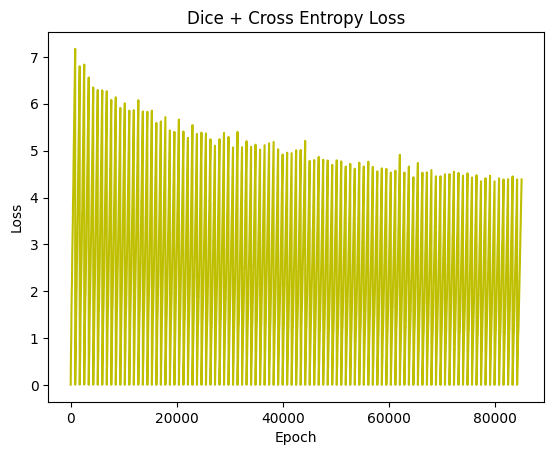

In [ ]:
# plot loss
plt.plot(train_logs,'y')
plt.title('Dice + Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() # comment this line if you are running on a server
plt.savefig(join(model_save_path, 'train_loss.png'))
plt.close()

In [ ]:
# Total score: 0.10158844366748968, IOU: 0.7976904511385001, DICE: 0.8525331889063669 || @ epoch 99.

In [ ]:
import torch.nn.functional as F

@torch.no_grad()
def sam_inference(sam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = sam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=True,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)
    # upscaled_masks = sam_model.postprocess_masks(low_res_pred, img_embed.shape, original_image_size).to(device)
    # binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

    # gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masks[k], (1, 1, ground_truth_masks[k].shape[0], ground_truth_masks[k].shape[1]))).to(device)
    # gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)

    # sam_seg = sam_seg.expand(-1, 3, -1, -1)
    low_res_pred = F.interpolate(
        low_res_logits,
        size=(C,H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    sam_seg = (low_res_pred > 0.5).astype(np.uint8)

    return sam_seg


In [ ]:
import torch.nn.functional as F
from torch.nn.functional import threshold, normalize

@torch.no_grad()
def sam_inference(sam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = sam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=True,
        )


    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)
    # print(low_res_pred.shape)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze(0).permute(1,2,0).cpu().numpy()  # (256, 256)
    print(low_res_pred.shape)
    sam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return sam_seg

In [ ]:
from skimage import io, transform

MedSAM_CKPT_PATH = "/content/drive/MyDrive/SAM/sam_only_T1/sam_model_best.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

# img_np = io.imread('/content/drive/MyDrive/SAM/image.0128.png')
# if len(img_np.shape) == 2:
#     img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
# else:
#     img_3c = img_np
# H, W, _ = img_3c.shape



In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[:2]#[-2:]
    mask_image = mask.reshape(h, w, 3) * color.reshape(3, 3, 3)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0][0], box[0][1]
    w, h = box[0][2] - box[0][0], box[0][3] - box[0][1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [ ]:
medsam_seg.shape[:2]

(256, 256)

  6%|▌         | 9/150 [00:00<00:04, 33.97it/s]

10
(256, 256, 3)


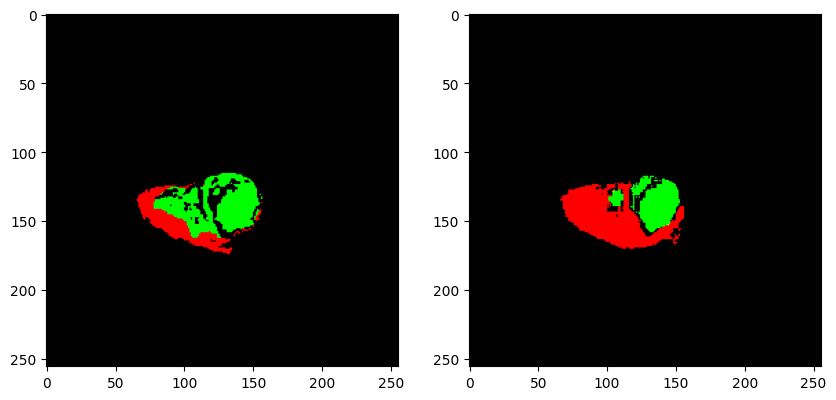

 15%|█▍        | 22/150 [00:01<00:07, 17.79it/s]

28
(256, 256, 3)


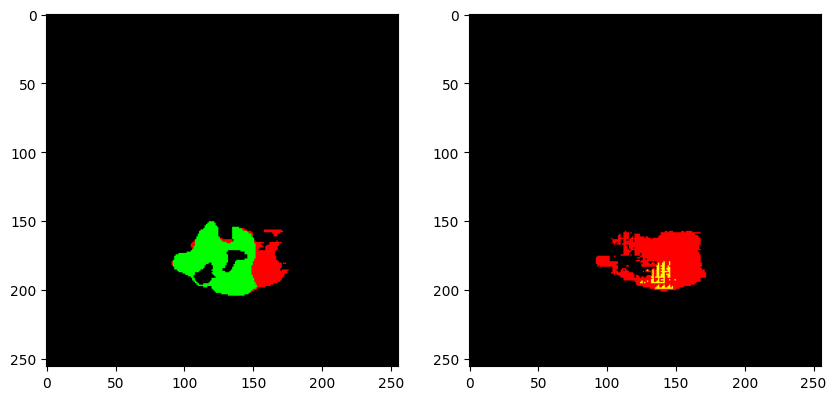

 25%|██▌       | 38/150 [00:02<00:05, 19.17it/s]

41
(256, 256, 3)


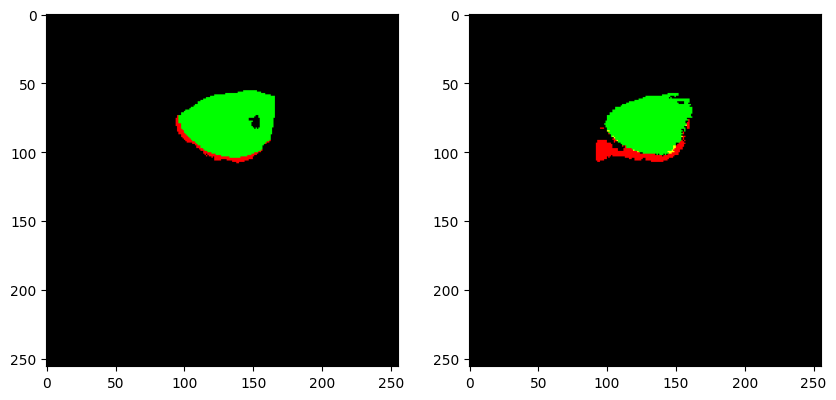

 29%|██▊       | 43/150 [00:03<00:08, 11.92it/s]

50
(256, 256, 3)


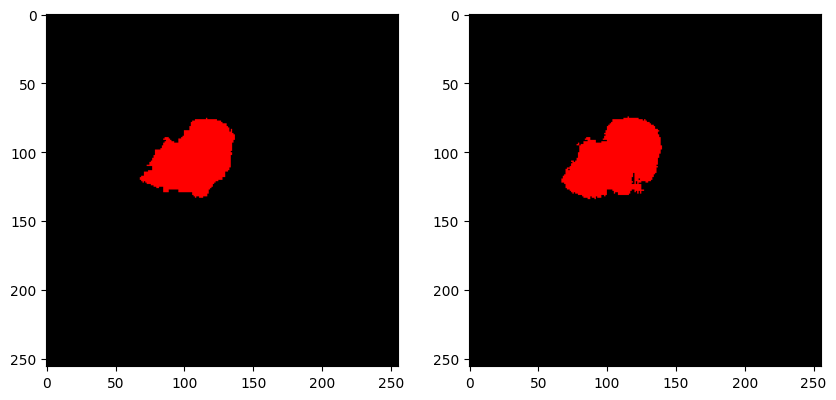

 41%|████      | 61/150 [00:04<00:05, 16.19it/s]

61
(256, 256, 3)


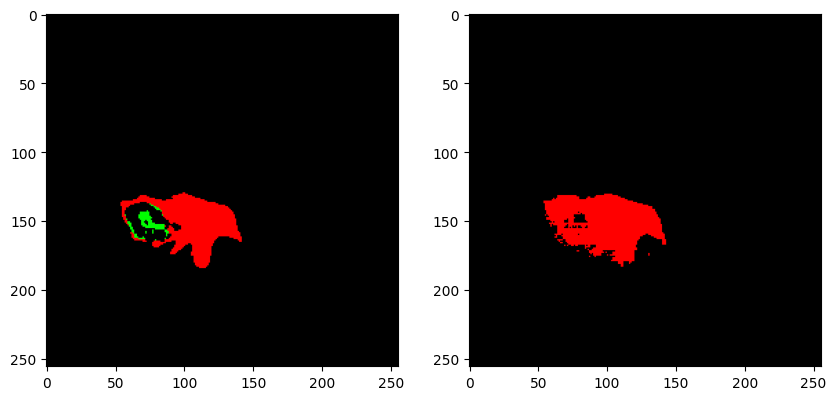

 44%|████▍     | 66/150 [00:05<00:07, 11.84it/s]

72
(256, 256, 3)


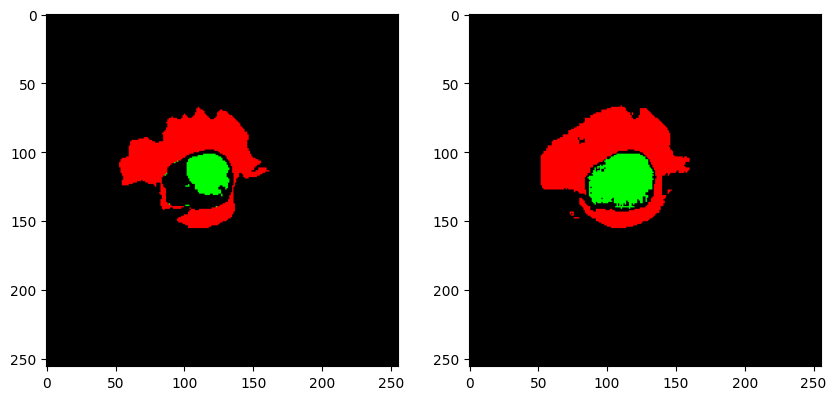

 59%|█████▉    | 89/150 [00:06<00:03, 19.67it/s]

90
(256, 256, 3)


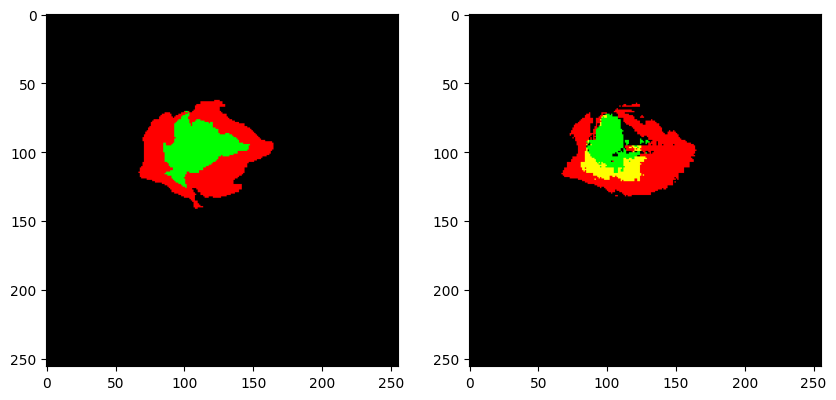

91
(256, 256, 3)


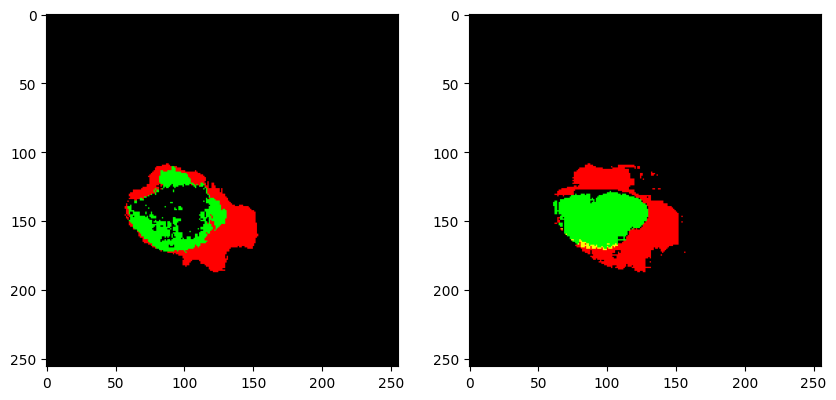

 69%|██████▊   | 103/150 [00:07<00:03, 13.19it/s]

105
(256, 256, 3)


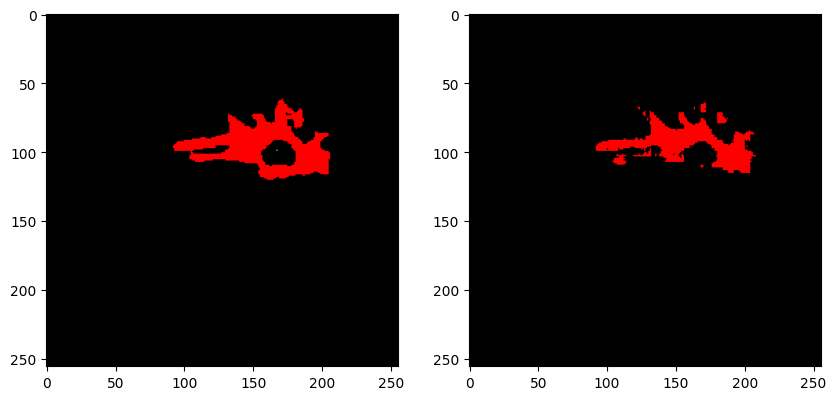

 72%|███████▏  | 108/150 [00:08<00:04, 10.39it/s]

110
(256, 256, 3)


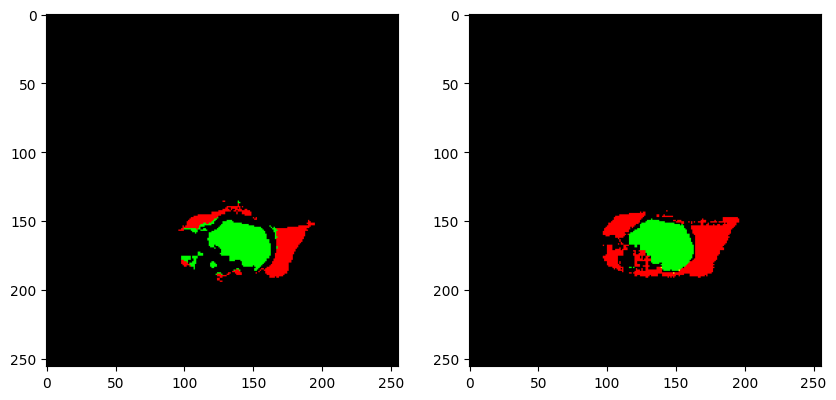

100%|██████████| 150/150 [00:10<00:00, 14.03it/s]


In [ ]:
for step, (image_embedding, gt2D, boxes) in enumerate(tqdm(valid_dl)):
  # if step == 19:
    global img_temp
    val, counts = np.unique(gt2D, return_counts=True)
    if(1 - (counts[0]/counts.sum())) > 0.01:
      print(step)
      img_temp = image_embedding
      sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
      trans_image = sam_trans.apply_image_torch(img_temp)
      trans_image = trans_image.float()
      trans_image = trans_image.to(device)
      image = trans_image
      mask = gt2D
      mask = mask.squeeze(0)
      mask = (mask.permute(1,2,0))
      bbox = boxes
      img_3c = img_temp.squeeze(0)
      img_3c = img_3c.permute(1,2,0).cpu().numpy()
      B,C,H, W, = img_temp.shape
      box_np = np.array(bbox)
      # rect = patches.Rectangle((bbox[0][0], bbox[0][1]), bbox[0][2] - bbox[0][0],bbox[0][3] - bbox[0][1], linewidth=1, edgecolor='r', facecolor='none')
      # transfer box_np t0 1024x1024 scale
      box_1024 = box_np / np.array([W, H, W, H]) * 1024
      with torch.no_grad():
          image_emb = medsam_model.image_encoder(image) # (1, 256, 64, 64)

      medsam_seg = sam_inference(medsam_model,image_emb , box_1024, H, W)
      # medsam_seg = medsam_seg.transpose(1,2,0)
      # print(medsam_seg.shape)

      #%% visualize results
      fig, ax = plt.subplots(1, 2, figsize=(10, 5))
      # ax.imshow(img_3c)
      # show_box(box_np, ax)
      # ax.set_title("Input Image and Bounding Box")
      # ax.imshow(img_3c)
      ax[0].imshow(mask)
      ax[1].imshow(medsam_seg*255)
      # show_mask(medsam_seg, ax[1])
      # show_box(box_np, ax)
      # ax.set_title("Segmentation")
      plt.show()
      # print(img_3c.shape)

      # print(image.shape)
      # print(mask.shape)
      # print(bboxes)

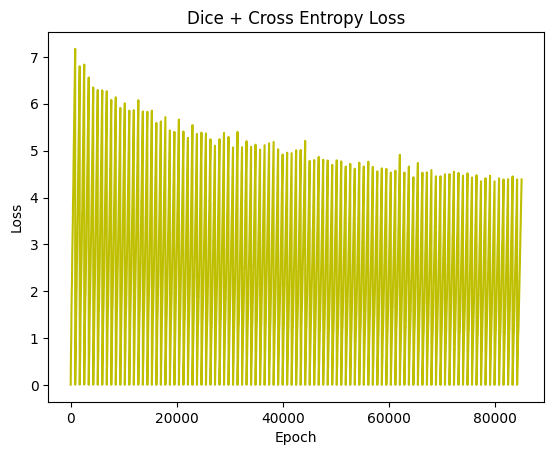

In [ ]:
# plot loss
plt.plot(train_logs,'y')
plt.title('Dice + Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() # comment this line if you are running on a server
plt.savefig(join(model_save_path, 'train_loss.png'))
plt.close()

In [ ]:
img_3c.shape

(256, 256, 3)

In [ ]:
for step, (images, masks, bboxes) in enumerate(tqdm(valid_dl)):
  # print(bboxes)
  if step == 1:
    print('yes')
    global image_temp

    val, counts = np.unique(masks, return_counts=True)
    # print(1 - (counts[0]/counts.sum()))
    if(1 - (counts[0]/counts.sum())) > 0.01:
      print(str(step)+'step')
      image_temp = images
      #images = images
      plt.imshow(images.squeeze(0).permute(1,2,0).cpu().numpy())
      print(image_temp.shape)



  3%|▎         | 15/508 [00:00<00:07, 65.73it/s]

yes


100%|██████████| 508/508 [00:03<00:00, 140.59it/s]


In [ ]:
for step, (image_embedding, gt2D, boxes) in enumerate(tqdm(valid_dl)):
  # if step == 19:
    global img_temp
    val, counts = np.unique(gt2D, return_counts=True)
    if(1 - (counts[0]/counts.sum())) > 0.01:
      print(step)
      img_temp = image_embedding
      sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
      trans_image = sam_trans.apply_image_torch(img_temp)
      trans_image = trans_image.float()
      trans_image = trans_image.to(device)
      image = trans_image
      mask = gt2D
      bbox = boxes


      print(image.shape)
      print(mask.shape)
      print(bboxes)





 42%|████▏     | 10/24 [00:00<00:00, 45.35it/s]

1
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 256, 256])
tensor([[0, 0, 0, 0]])
9
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 256, 256])
tensor([[0, 0, 0, 0]])
10
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 256, 256])
tensor([[0, 0, 0, 0]])
11
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 256, 256])
tensor([[0, 0, 0, 0]])


100%|██████████| 24/24 [00:00<00:00, 54.85it/s]


In [ ]:
img_3c = img_temp.squeeze(0)
img_3c = img_3c.permute(1,2,0).cpu().numpy()
print(img_3c.shape)

(256, 256, 3)


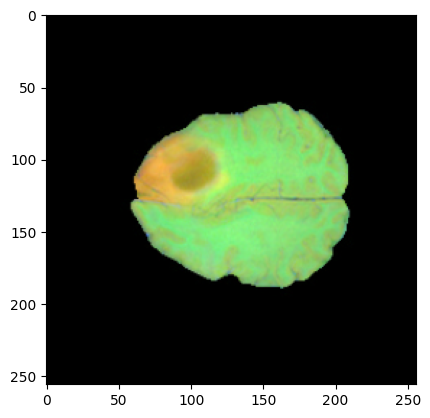

In [ ]:
plt.imshow(img_3c)
plt.show()

In [ ]:
mask = mask.squeeze(0)
mask = (mask.permute(1,2,0))

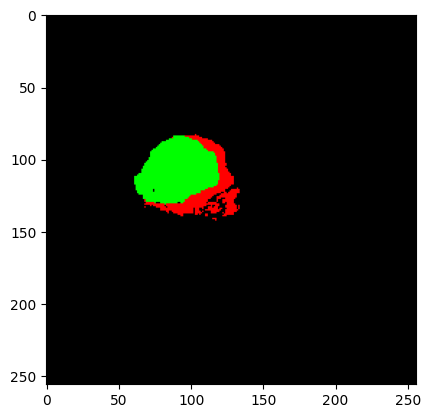

In [ ]:
plt.imshow(mask,cmap = 'bone')
plt.show()

In [ ]:
B,C,H, W, = img_temp.shape

1024

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask * color#.reshape(1, 1, -1)#.reshape(h, w, 1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0][0], box[0][1]
    w, h = box[0][2] - box[0][0], box[0][3] - box[0][1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [ ]:
import torch.nn.functional as F

@torch.no_grad()
def sam_inference(sam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = sam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)
    print(low_res_pred.shape)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    print(low_res_pred.shape)
    # low_res_pred = low_res_pred.expand(-1, 3, -1, -1)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256).permute(1,2,0)

    print(low_res_pred.shape)
    sam_seg = (low_res_pred > 0.5).astype(np.uint8)

    return sam_seg

In [ ]:
# img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)

# img_1024 = (img_1024 - img_1024.min()) / np.clip(
#     img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
# )  # normalize to [0, 1], (H, W, 3)
# # convert the shape to (3, H, W)
# sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)

# img_1024_tensor = torch.tensor(img_3c).float().permute(2, 0, 1).unsqueeze(0).to(device)
# trans_image =sam_model.preprocess(img_3c)
box_np = np.array([[ 67,  74, 154, 147]])
# rect = patches.Rectangle((bbox[0][0], bbox[0][1]), bbox[0][2] - bbox[0][0],bbox[0][3] - bbox[0][1], linewidth=1, edgecolor='r', facecolor='none')
# transfer box_np t0 1024x1024 scale
box_1024 = box_np / np.array([W, H, W, H]) * 1024
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(image) # (1, 256, 64, 64)

medsam_seg = sam_inference(medsam_model, image_embedding, box_1024, H, W)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
(256, 256)


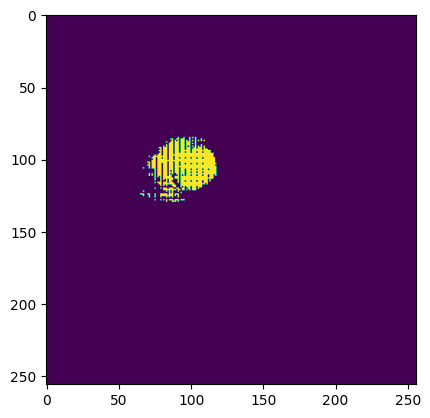

In [ ]:
plt.imshow(medsam_seg)
plt.show()

ValueError: ignored

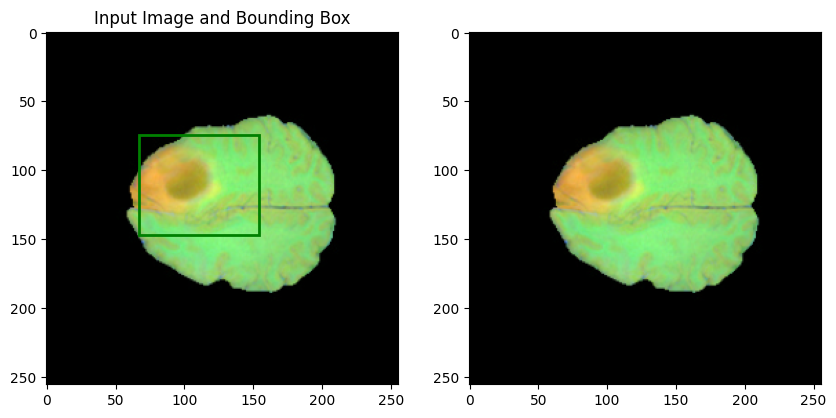

In [ ]:
#%% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_3c)
show_box(box_np, ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(img_3c)
show_mask(medsam_seg, ax[1])
show_box(box_np, ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()

In [ ]:
from segment_anything import sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import monai
optimizer = torch.optim.Adam([
    dict(params=sam_model.parameters(), lr=1e-5, weight_decay=0),
])

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

num_epochs = 3
losses = []
best_loss = 1e10
for epoch in range(num_epochs):
    epoch_loss = 0
    # train
    for step, (image_embedding, gt2D, boxes) in enumerate(tqdm(train_dl)):
      val, counts = np.unique(gt2D, return_counts=True)
      if(1 - (counts[0]/counts.sum())) > 0.01:
        # image_embedding = image_embedding.repeat(1, 3, 1, 1)
        sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
        trans_image = sam_trans.apply_image_torch(image_embedding)
        trans_image = trans_image.float()
        trans_image = trans_image.to(device)

        # print(image_embedding.size(0))
        # do not compute gradients for image encoder and prompt encoder
        with torch.no_grad():
            image_embedding = sam_model.image_encoder(trans_image)
            # convert box to 1024x1024 grid
            box_np = boxes.numpy()
            sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
            box = sam_trans.apply_boxes(box_np, (gt2D.shape[-2], gt2D.shape[-1]))
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :] # (B, 1, 4)

            # print(image_embedding.shape)
            # print(gt2D.shape)
            # get prompt embeddings
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )

            # if num_classes > 1:
            #     multimask_output = True
            # else:
            #     multimask_output = False

            # mask_predictions = image_embedding.size * 3


        # predicted masks
        batch_size = image_embedding.size(0)
        dense_prompt_embeddings = dense_embeddings.repeat(batch_size, 1, 1, 1)

        mask_predictions, _ = sam_model.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_prompt_embeddings, #dense_embeddings.repeat(image_embedding.size(0), 1, 1, 1), # (B, 256, 64, 64)
            multimask_output=True,
          )

        # mask_predictions = image_embedding.size * 4


        # if num_classes > 1:
        #     multimask_output = True
        # else:
        #     multimask_output = False

        # mask_predictions = image_embedding.size * 4

        loss = seg_loss(mask_predictions, gt2D.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        time_end = time.time()
        print('time_for_training ', time_end - time_start)

    epoch_loss /= step
    losses.append(epoch_loss)
    print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
    # save the latest model checkpoint
    torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_latest.pth'))
    # save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_best.pth'))

  6%|▋         | 11/170 [00:00<00:11, 14.12it/s]

time_for_training  397.59735345840454


 15%|█▌        | 26/170 [00:01<00:07, 20.52it/s]

time_for_training  398.16206789016724


 18%|█▊        | 30/170 [00:01<00:09, 15.46it/s]

time_for_training  398.6722958087921


 25%|██▍       | 42/170 [00:02<00:07, 17.96it/s]

time_for_training  399.21668124198914


 34%|███▍      | 58/170 [00:02<00:05, 21.77it/s]

time_for_training  399.7751410007477


 42%|████▏     | 71/170 [00:03<00:04, 22.43it/s]

time_for_training  400.32246470451355


 44%|████▎     | 74/170 [00:04<00:05, 17.38it/s]

time_for_training  400.82293915748596


 46%|████▌     | 78/170 [00:04<00:06, 14.57it/s]

time_for_training  401.3274381160736


 55%|█████▌    | 94/170 [00:05<00:03, 19.07it/s]

time_for_training  401.8925235271454


 68%|██████▊   | 115/170 [00:05<00:01, 27.70it/s]

time_for_training  402.4025402069092


 72%|███████▏  | 123/170 [00:06<00:02, 23.33it/s]

time_for_training  403.0220229625702


 85%|████████▌ | 145/170 [00:06<00:00, 31.36it/s]

time_for_training  403.53092885017395
time_for_training  404.1457760334015


 90%|█████████ | 153/170 [00:07<00:00, 18.36it/s]

time_for_training  404.6748847961426


 94%|█████████▎| 159/170 [00:08<00:00, 16.18it/s]

time_for_training  405.19812774658203


 96%|█████████▋| 164/170 [00:08<00:00, 14.30it/s]

time_for_training  405.73215508461


 99%|█████████▉| 168/170 [00:09<00:00, 12.35it/s]

time_for_training  406.26084184646606


100%|██████████| 170/170 [00:10<00:00, 16.93it/s]

time_for_training  406.7647166252136
EPOCH: 0, Loss: 0.06250970567810162



  6%|▋         | 11/170 [00:00<00:10, 15.05it/s]

time_for_training  409.65279054641724


 15%|█▌        | 26/170 [00:01<00:06, 21.00it/s]

time_for_training  410.2261049747467


 18%|█▊        | 30/170 [00:01<00:09, 15.37it/s]

time_for_training  410.7613425254822


 25%|██▍       | 42/170 [00:02<00:07, 17.69it/s]

time_for_training  411.32184314727783


 34%|███▍      | 58/170 [00:03<00:05, 21.21it/s]

time_for_training  411.90627002716064


 42%|████▏     | 71/170 [00:03<00:04, 21.75it/s]

time_for_training  412.4759044647217


 44%|████▎     | 74/170 [00:04<00:05, 16.78it/s]

time_for_training  412.9999563694


 46%|████▌     | 78/170 [00:04<00:06, 14.10it/s]

time_for_training  413.51763224601746


 55%|█████▌    | 94/170 [00:05<00:04, 18.50it/s]

time_for_training  414.09759283065796


 67%|██████▋   | 114/170 [00:05<00:02, 26.09it/s]

time_for_training  414.6354184150696


 72%|███████▏  | 123/170 [00:06<00:02, 22.57it/s]

time_for_training  415.2832808494568


 85%|████████▍ | 144/170 [00:07<00:00, 29.65it/s]

time_for_training  415.79608488082886


 89%|████████▉ | 152/170 [00:07<00:00, 24.02it/s]

time_for_training  416.432471036911
time_for_training  416.9923598766327


 93%|█████████▎| 158/170 [00:08<00:00, 14.45it/s]

time_for_training  417.50508093833923


 96%|█████████▌| 163/170 [00:09<00:00, 13.09it/s]

time_for_training  418.04609394073486


 99%|█████████▉| 168/170 [00:09<00:00, 12.02it/s]

time_for_training  418.5824589729309


100%|██████████| 170/170 [00:10<00:00, 16.57it/s]

time_for_training  419.1028845310211
EPOCH: 1, Loss: 0.06102256722716531



  6%|▋         | 11/170 [00:00<00:11, 14.35it/s]

time_for_training  422.0838279724121


 15%|█▌        | 26/170 [00:01<00:07, 20.34it/s]

time_for_training  422.66764068603516


 18%|█▊        | 30/170 [00:01<00:09, 15.05it/s]

time_for_training  423.20531010627747


 25%|██▍       | 42/170 [00:02<00:07, 17.44it/s]

time_for_training  423.76776361465454


 34%|███▍      | 58/170 [00:03<00:05, 21.00it/s]

time_for_training  424.3540279865265


 42%|████▏     | 71/170 [00:03<00:04, 21.55it/s]

time_for_training  424.9283878803253


 44%|████▎     | 74/170 [00:04<00:05, 16.63it/s]

time_for_training  425.4565315246582


 46%|████▌     | 78/170 [00:04<00:06, 13.90it/s]

time_for_training  425.989164352417


 55%|█████▌    | 94/170 [00:05<00:04, 18.21it/s]

time_for_training  426.5789918899536


 66%|██████▌   | 112/170 [00:05<00:02, 24.02it/s]

time_for_training  427.14498949050903


 72%|███████▏  | 123/170 [00:06<00:02, 22.40it/s]

time_for_training  427.80783677101135


 84%|████████▍ | 143/170 [00:07<00:00, 28.25it/s]

time_for_training  428.34289264678955


 88%|████████▊ | 150/170 [00:07<00:00, 22.28it/s]

time_for_training  429.00527262687683
time_for_training  429.5761103630066


 92%|█████████▏| 156/170 [00:08<00:01, 13.53it/s]

time_for_training  430.1120274066925


 96%|█████████▌| 163/170 [00:09<00:00, 13.24it/s]

time_for_training  430.67301774024963


 99%|█████████▉| 168/170 [00:09<00:00, 12.07it/s]

time_for_training  431.2232551574707


100%|██████████| 170/170 [00:10<00:00, 16.15it/s]

time_for_training  431.7515239715576
EPOCH: 2, Loss: 0.05928551144412276


In [ ]:
print(f'Best Epoch:{best_loss}')

Best Epoch:0.018148347845010147


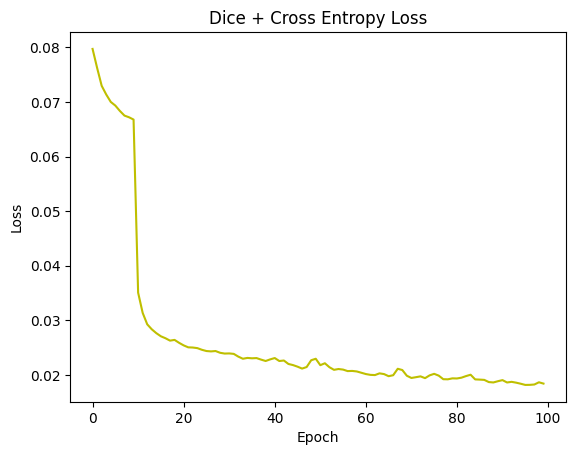

In [ ]:
# plot loss
plt.plot(losses,'y')
plt.title('Dice + Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() # comment this line if you are running on a server
plt.savefig(join(model_save_path, 'train_loss.png'))
plt.close()

In [ ]:
# Load up the model with default weights
sam_model_orig = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam_model_orig.to(device);

In [ ]:
# Set up predictors for both tuned and original models
from segment_anything import sam_model_registry, SamPredictor
predictor_tuned = SamPredictor(sam_model)
predictor_original = SamPredictor(sam_model_orig)


In [ ]:
import numpy as np
for images,masks,bboxes in valid_dl:
  images = images[0]
  # images = images.repeat(3, 1, 1)
  # images = torch.squeeze(images, dim=1)
  images = (images.permute(1,2,0).numpy())
  # images = images.float()

  print(images.shape)
  bboxes = bboxes
  predictor_tuned.set_image(images.astype(np.uint8))
  predictor_original.set_image(images.astype(np.uint8))

  input_bbox = (bboxes)
  input_bbox = input_bbox.numpy()

  masks_tuned, _, _ = predictor_tuned.predict(
      point_coords=None,
      box=input_bbox,
      multimask_output=False,
  )

  masks_orig, _, _ = predictor_original.predict(
      point_coords=None,
      box=input_bbox,
      multimask_output=False,
  )

  break
# low_res_pred = F.interpolate(
#         low_res_pred,
#         size=(H, W),
#         mode="bilinear",
#         align_corners=False,
#     )  # (1, 1, gt.shape)
# low_res_pred = masks_tuned.squeeze()  # (256, 256)
# medsam_seg = (low_res_pred > 0.5)*255

# masks_tuned  = masks_tuned.transpose(1,2,0)
print(masks_tuned.shape)
print(input_bbox)
bboxes.numpy()
a,b,test = predictor_tuned.predict(
      point_coords=None,
      box=input_bbox,
      multimask_output=False,
  )
print(b.shape )

(256, 256, 3)
(256, 256, 1)
[[0 0 0 0]]
(1,)


In [ ]:
bboxes

tensor([[ 54,  70, 162, 152]])

ValueError: ignored

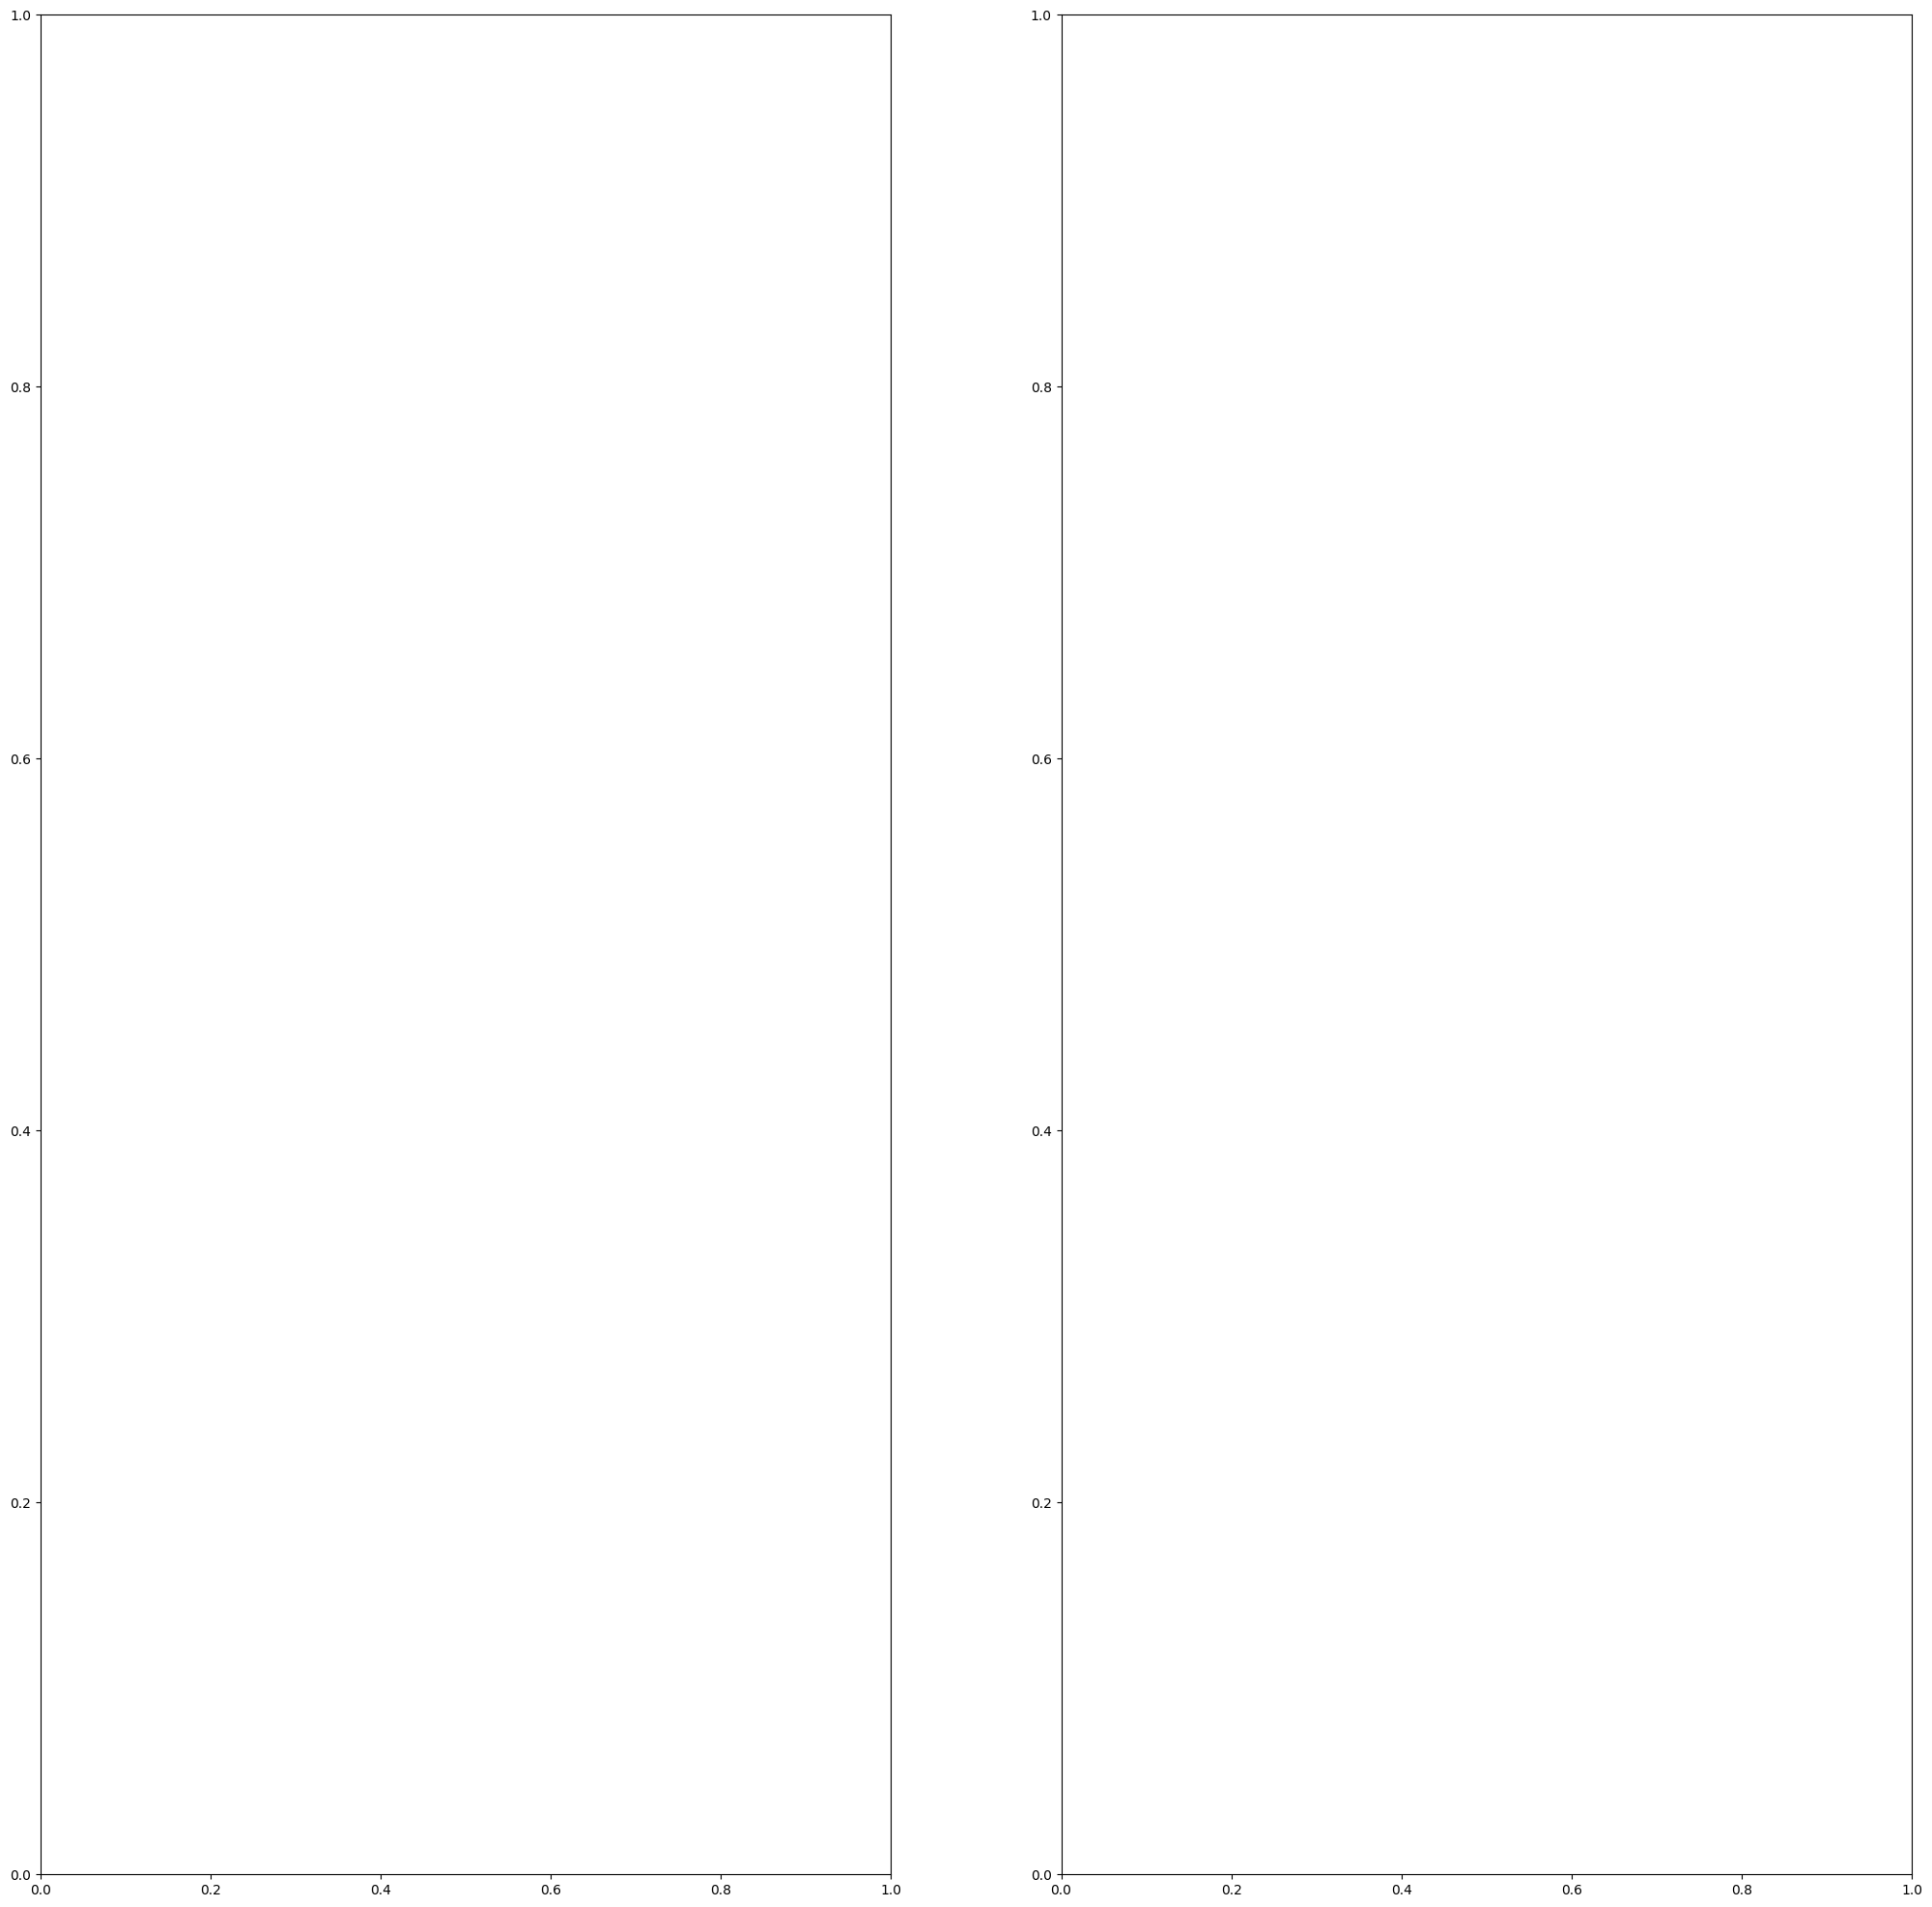

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(25, 25))
show_mask(masks_tuned,axs[0])

TypeError: ignored

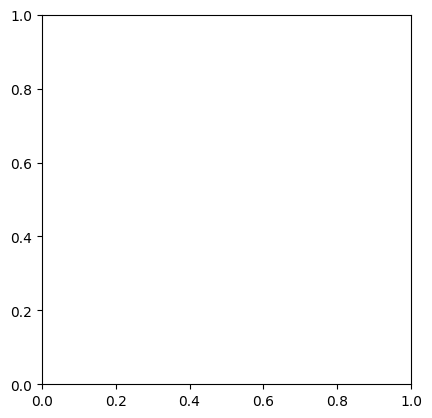

In [ ]:
plt.imshow(show_mask)
plt.show()

In [ ]:
masks_tuned.shape

(1, 256, 256)

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0][0], box[0][1]
    w, h = box[0][2] - box[0][0], box[0][3] - box[0][1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(sam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

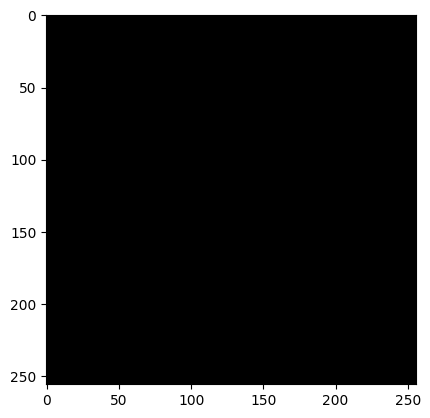

In [ ]:
plt.imshow(images)
plt.show()

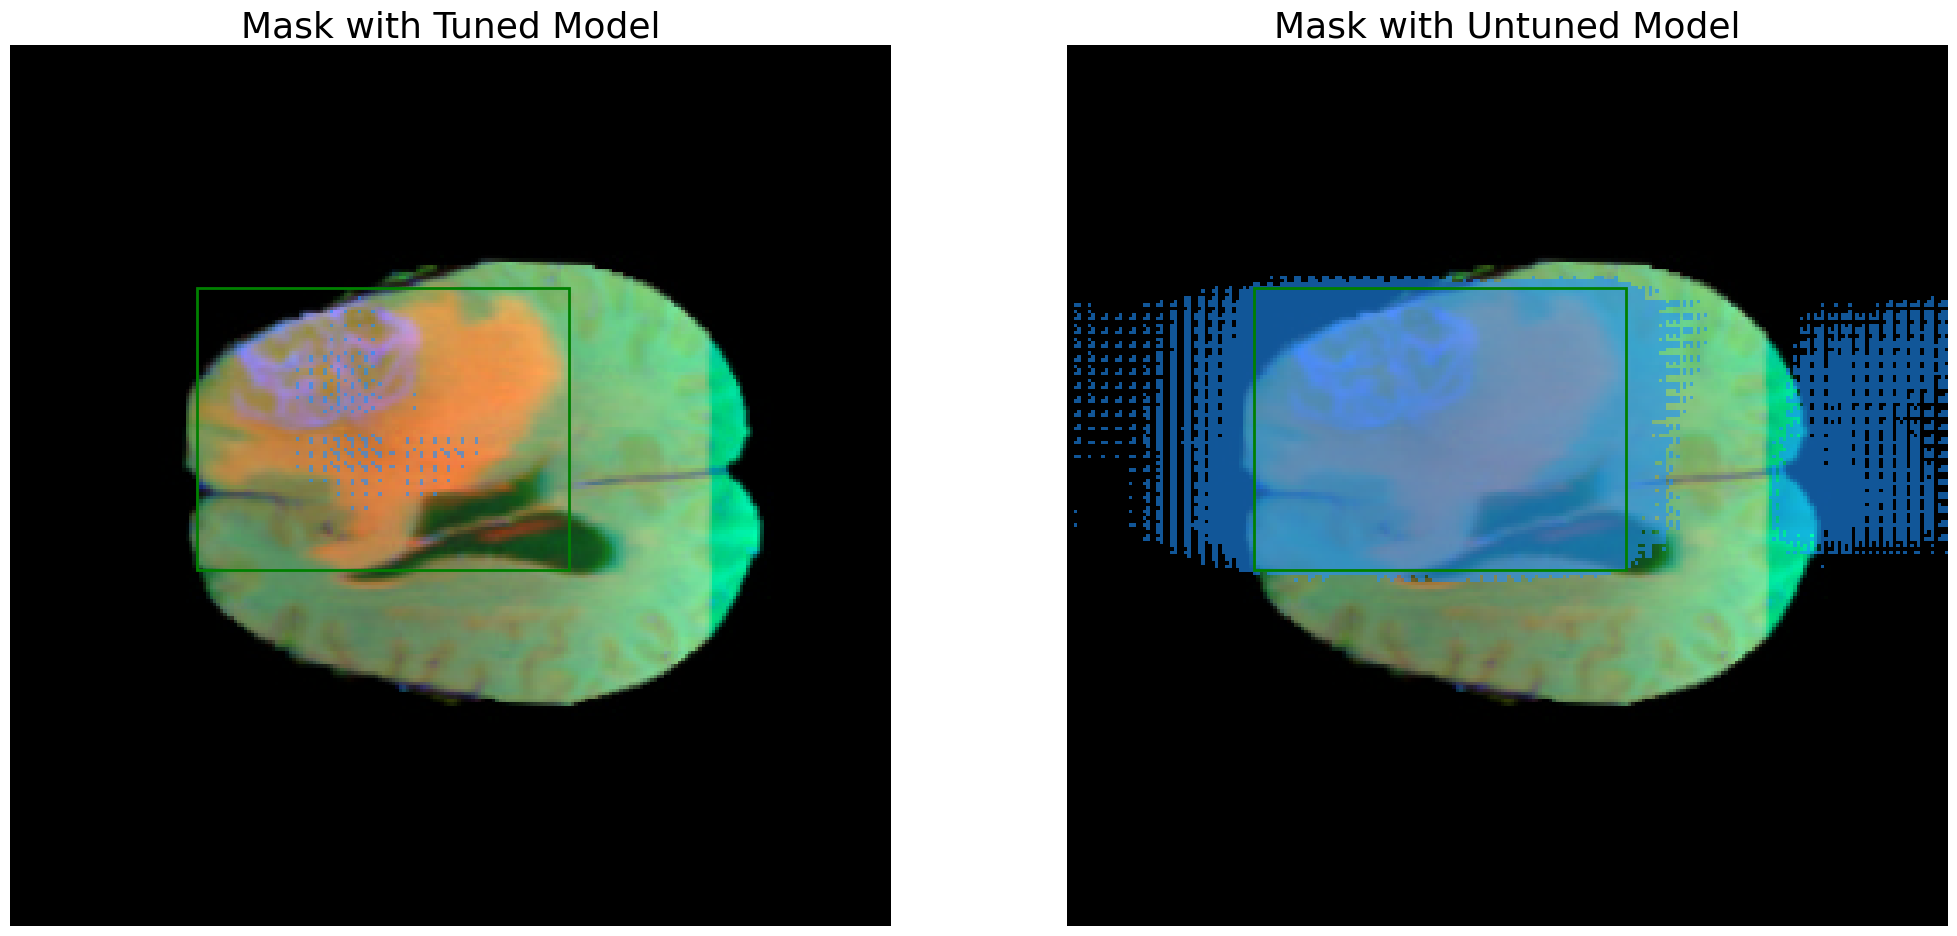

In [ ]:
import matplotlib
%matplotlib inline
_, axs = plt.subplots(1, 2, figsize=(25, 25))


axs[0].imshow(images)
show_mask(masks_tuned, axs[0])
show_box(input_bbox, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')


axs[1].imshow(images)
show_mask(masks_orig, axs[1])
show_box(input_bbox, axs[1])
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()

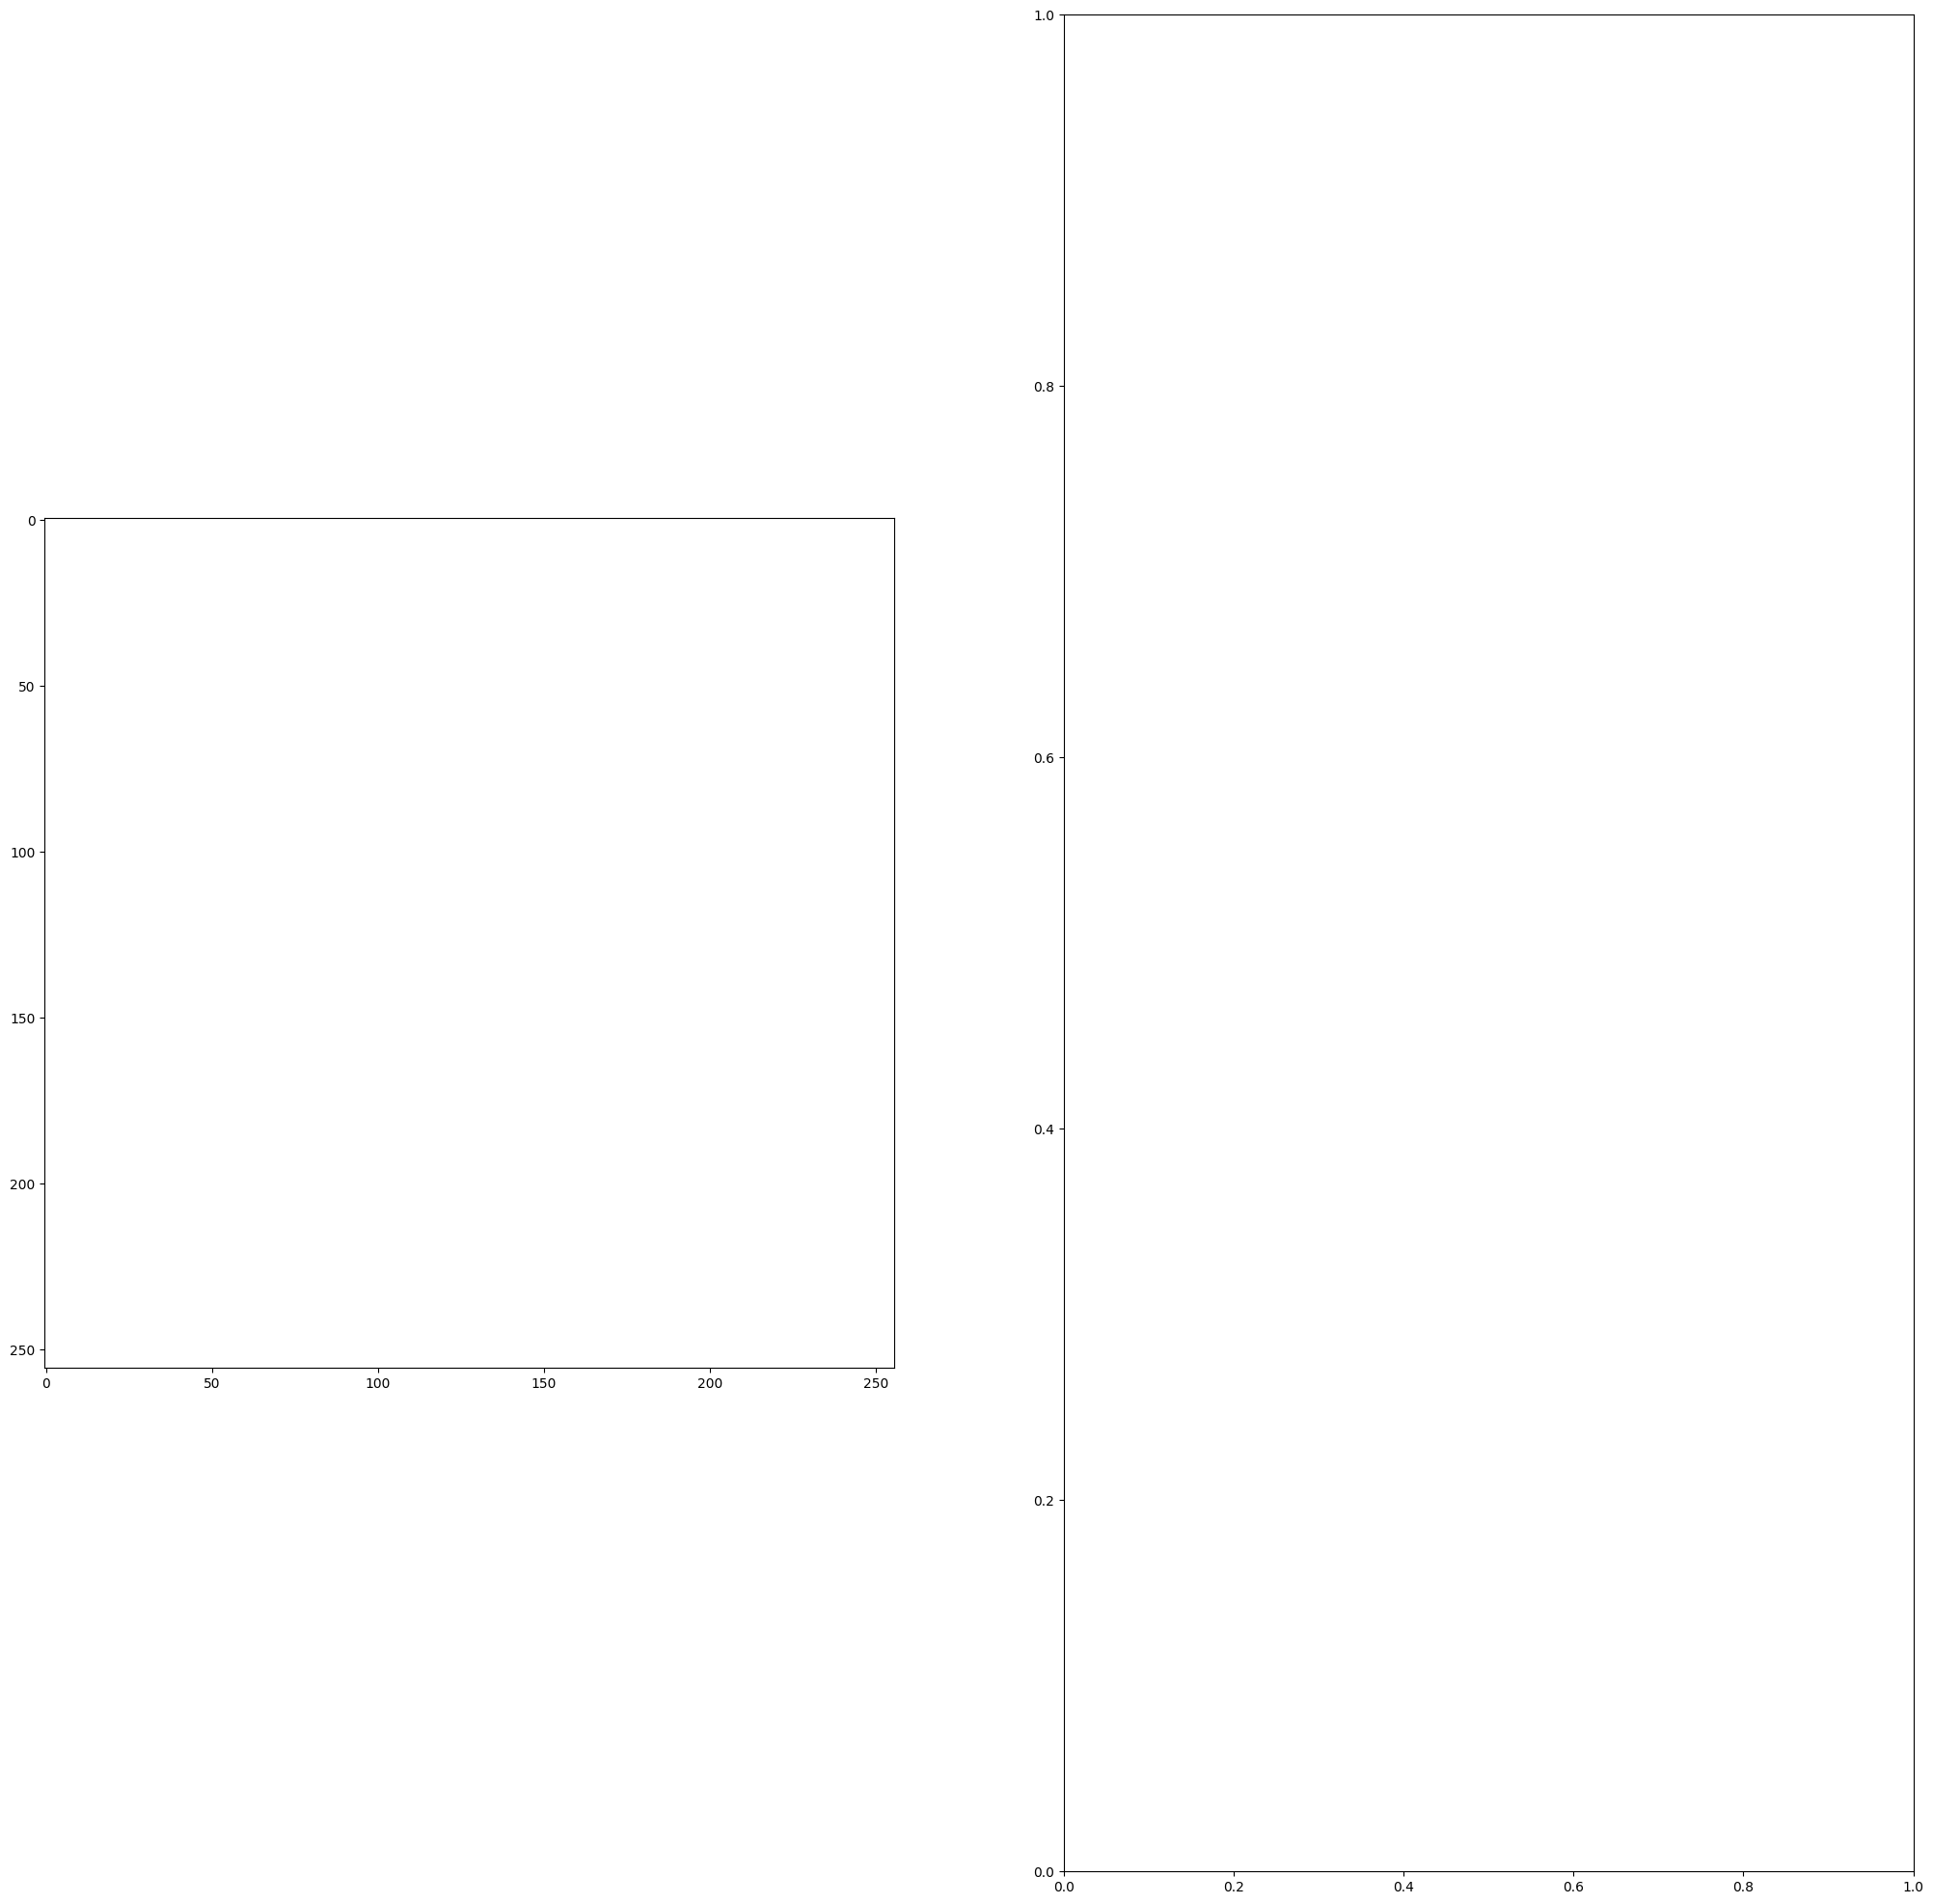

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(25, 25))

show_mask((masks_tuned), axs[0])